# Experimental Design

## Author: Maycon Leone M. Peixoto

### Description:
This notebook contains exploratory data analyses and statistical modeling for a project. This code performs the design of a full factorial 2^k experiment, where k is the number of factors, using the pandas library for data manipulation, itertools to generate combinations of factor levels, numpy for numerical calculations, and re for regular expressions. The user inputs the number of factors and their names, the real levels for each factor, and the number and names of the response variables. The code calculates all possible combinations of factor levels (-1 and 1 representing low and high levels, respectively), asks the user to provide experimental data, verifies the correctness of this data, and organizes it into a pandas DataFrame.

The code also generates all possible interactions between factors and adjusts the coded levels to the real levels. Finally, a function calculates the effects and sum of squares (SS) for each factor and interaction, for each response variable. 

This script is useful for statistical analysis of experiments, allowing the user to explore the impact of various factors and their interactions on the response variables of interest.

**Note:** This project was developed as part of the Performance Evaluation Course 


In [1]:
import glob
import itertools

import pandas as pd
import numpy as np
from scipy import stats

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
file_list = glob.glob('csv/*.csv')

n = len(file_list) # Número de sementes: 10 (Número de arquivos lido)
dfs = [pd.read_csv(file) for file in file_list]

df = pd.concat(dfs)
df.head(2)

seed             id algoritmo  prob_add_carros  range_no_data  \
0  794161987    II-0.4-50-7        II              0.4             50   
1  794161987  II-0.4-50-all        II              0.4             50   

  pista_problematica  stepLast  tempo_medio_viagem  tempo_medio_velocidade  \
0                  7    360001           31.787014               25.031978   
1                all     58921          122.050000               12.597693   

   qtd_colisoes  total_veh_inseridos  qtd_veiculos_finalizam_execucao  \
0           0.0                 2934                             2906   
1           1.0                  480                              250   

   qtd_veiculos_executando  
0                       28  
1                      230

In [3]:
lista_index = ['algoritmo', 'prob_add_carros', 'range_no_data','pista_problematica']
var_resposta = list(set(df.columns) - set(lista_index+["id","seed",'total_veh_inseridos','stepLast']))

### Calculo por cenário separado, para as 10 sementes

In [4]:
grouped = df.drop(columns=['seed','id']).groupby(lista_index).agg(['mean','std']).reset_index()
#Cirando coluna ID para o gráfico de barra com intervalo de confiança
grouped['id'] = grouped[lista_index].apply(lambda x: '-'.join(x.astype(str)), axis=1)
grouped.sort_values(by=['prob_add_carros', 'range_no_data','pista_problematica','algoritmo'],ascending=[True, True,True,True], inplace=True)

grouped.head(2)

algoritmo prob_add_carros range_no_data pista_problematica  stepLast       \
                                                                  mean  std   
0     GIVAC             0.4            50                  7  360001.0  0.0   
8        II             0.4            50                  7  360001.0  0.0   

  tempo_medio_viagem           tempo_medio_velocidade           qtd_colisoes  \
                mean       std                   mean       std         mean   
0          31.527384  0.034876              25.200962  0.016127          0.0   
8          31.795140  0.116682              25.023263  0.063141          0.0   

       total_veh_inseridos            qtd_veiculos_finalizam_execucao  \
   std                mean        std                            mean   
0  0.0              2914.3  37.049666                          2884.8   
8  0.0              2914.3  37.049666                          2884.6   

             qtd_veiculos_executando                        id  
         std                    mean       std                  
0  35.530269                    29.5  4.672615  GIVAC-0.4-50-7  
8  35.547152                    29.7  4.831609     II-0.4-50-7

In [5]:
def calc_interval(grouped,var_resposta,n = 10,column_x = 'id', rotation = 0, z = stats.norm.ppf(0.975)):
    for var in var_resposta:
        #Calculo do erro médio para o intervalo de confiança
        grouped[(var, 'mean_error')] = z * (grouped[(var, 'std')] / np.sqrt(n))

In [6]:
calc_interval(grouped,var_resposta)

### Variáveis

In [7]:
num_factors = len(lista_index)
factor_names = lista_index
factor_levels_real = {factor:list(grouped[factor].unique()) for factor in factor_names}

In [8]:
num_response_vars = len(var_resposta)
response_vars_names = var_resposta

In [9]:
# Calculating the total number of experiments
total_experiments = 2 ** num_factors

In [10]:
# Preparing the DataFrame
level_combinations = list(itertools.product([-1, 1], repeat=num_factors))
experiment_design_df = pd.DataFrame(level_combinations, columns=factor_names)
experiment_design_df.insert(0, 'Exp', range(1, len(experiment_design_df) + 1))

In [11]:
for var_name in response_vars_names:
    experiment_design_df[var_name] = grouped[var_name]['mean']
    experiment_design_df[var_name+'_err'] = grouped[var_name]['mean_error']

In [12]:
# Generating interactions between factors
interaction_columns = []
for combo_length in range(2, num_factors + 1):
    for combo in itertools.combinations(factor_names, combo_length):
        interaction_name = ':'.join(combo)
        experiment_design_df[interaction_name] = np.prod(experiment_design_df[list(combo)], axis=1)
        interaction_columns.append(interaction_name)

In [13]:
# Adjusting real levels in the real experiment settings
experiment_settings_real_df = experiment_design_df.copy()
for factor_name in factor_names:
    experiment_settings_real_df[factor_name] = experiment_settings_real_df[factor_name].map({-1: factor_levels_real[factor_name][0], 1: factor_levels_real[factor_name][1]})

In [14]:
# Function to calculate the effects and SS
def calculate_effects_SS_dynamic(df, response_var_names):
    results = {}
    for response_var_name in response_var_names:
        n = len(df)
        response_values = df[response_var_name].values
        factor_columns = [col for col in df.columns if col not in ['Exp'] + response_var_names]
        effects = {}
        SS = {}

        for factor in factor_columns:
            factor_values = df[factor].values
            effect = np.sum(factor_values * response_values) / n
            effects[factor] = effect
            SS[factor] = n * effect ** 2

        SST = np.sum((response_values - np.mean(response_values)) ** 2)
        results[response_var_name] = (effects, SS, SST)
    return results

# Function to print formatted results
def print_formatted_results(results):
    for response_var_name, (effects, SS, SST) in results.items():
        print(f"\n{response_var_name} - Effects of Factors and Interactions:")
        for name, effect in effects.items():
            print(f"  {name}: {effect:.4f}")
        print(f"\n{response_var_name} - Sum of Squares (SS) for each Factor and Interaction:")
        for name, ss in SS.items():
            print(f"  {name}: {ss:.4f}")
        print(f"\n{response_var_name} - Total Sum of Squares (SST): {SST:.4f}")
        print(f"\n{response_var_name} - Percentage Influence of each Factor and Interaction:")
        for name, ss in SS.items():
            print(f"  {name}: {(ss / SST) * 100:.2f}%")

## Gráfico 1

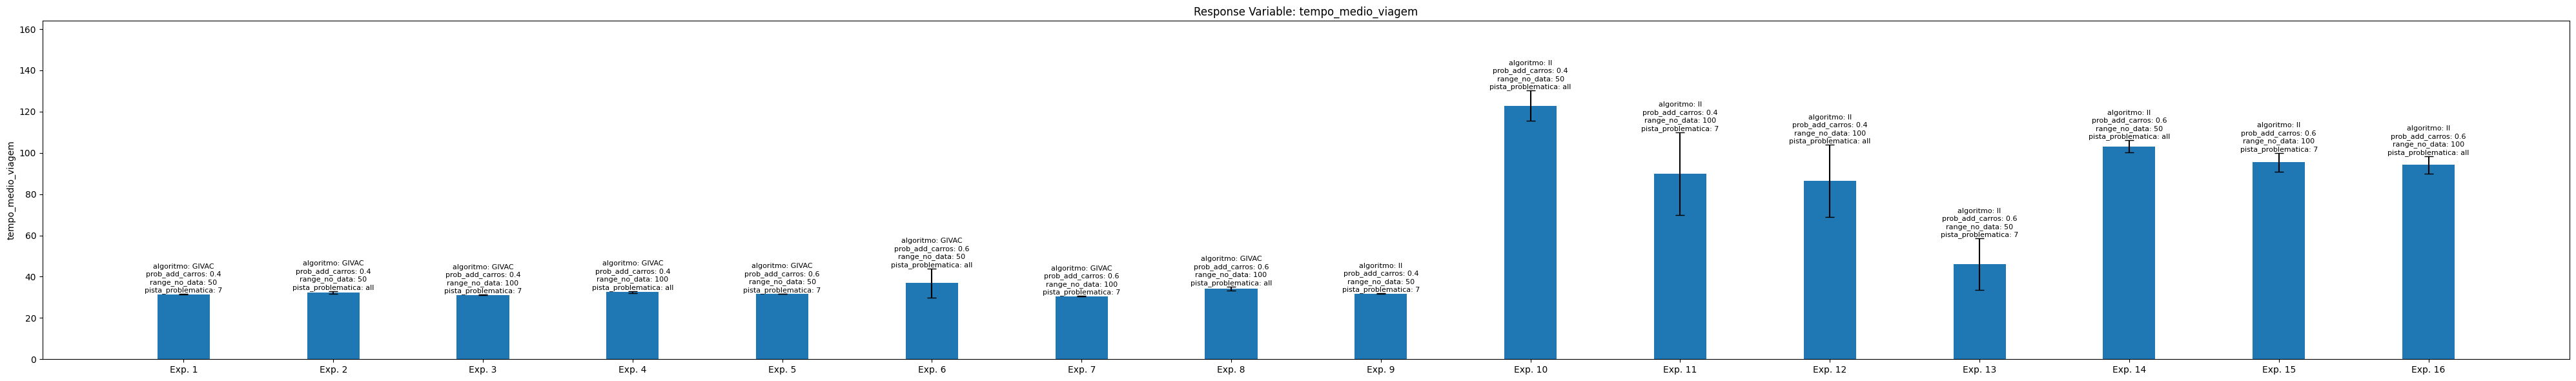

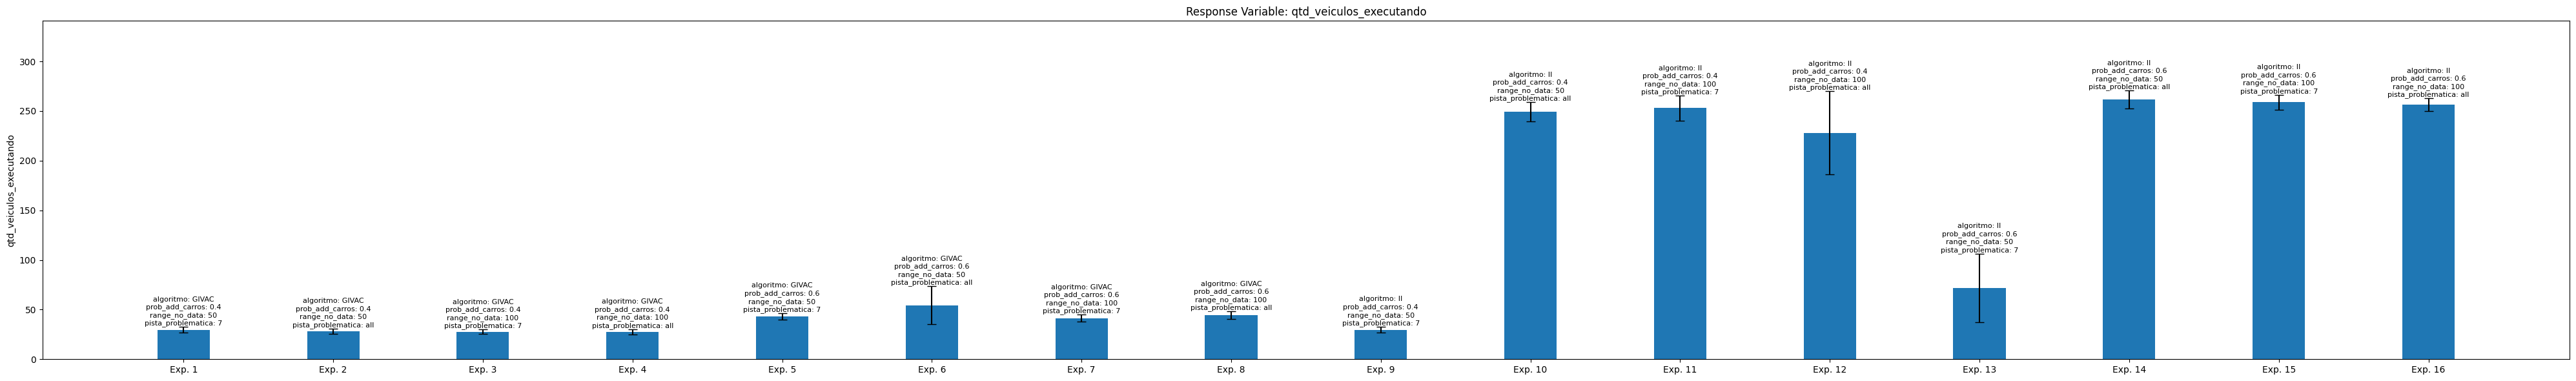

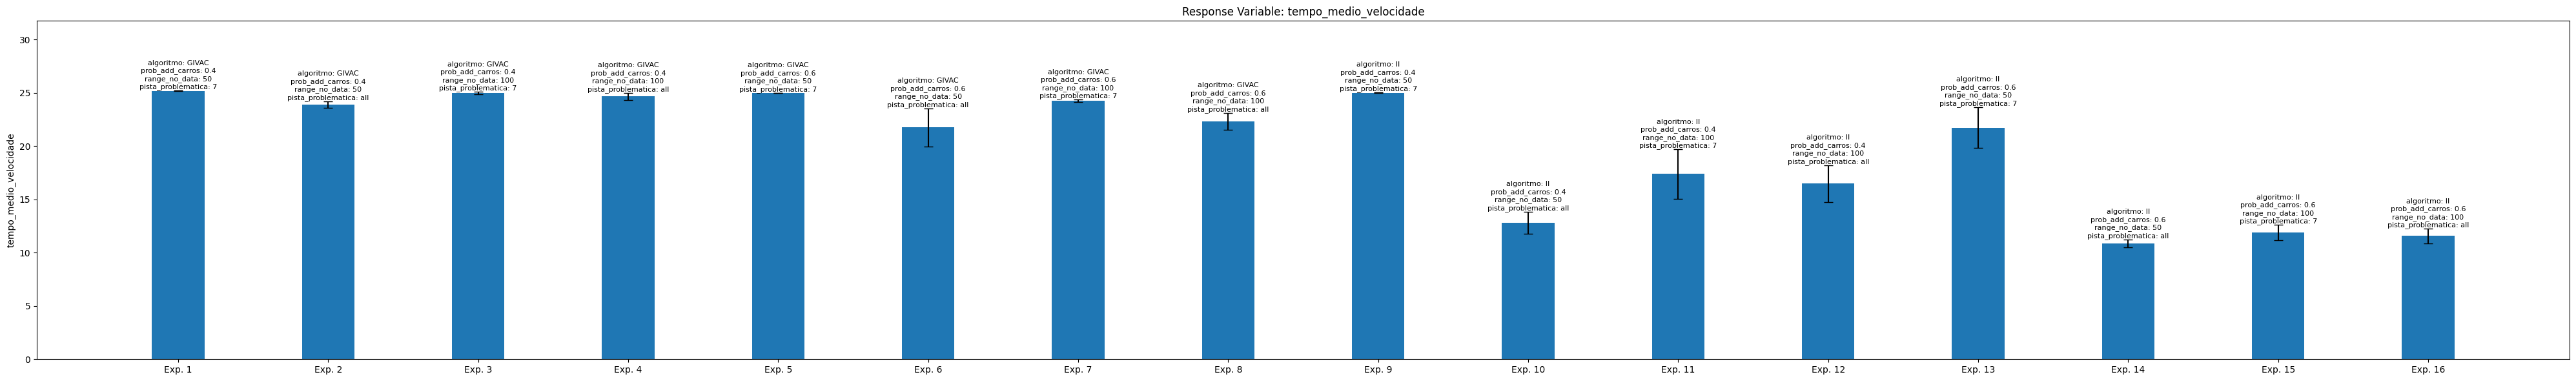

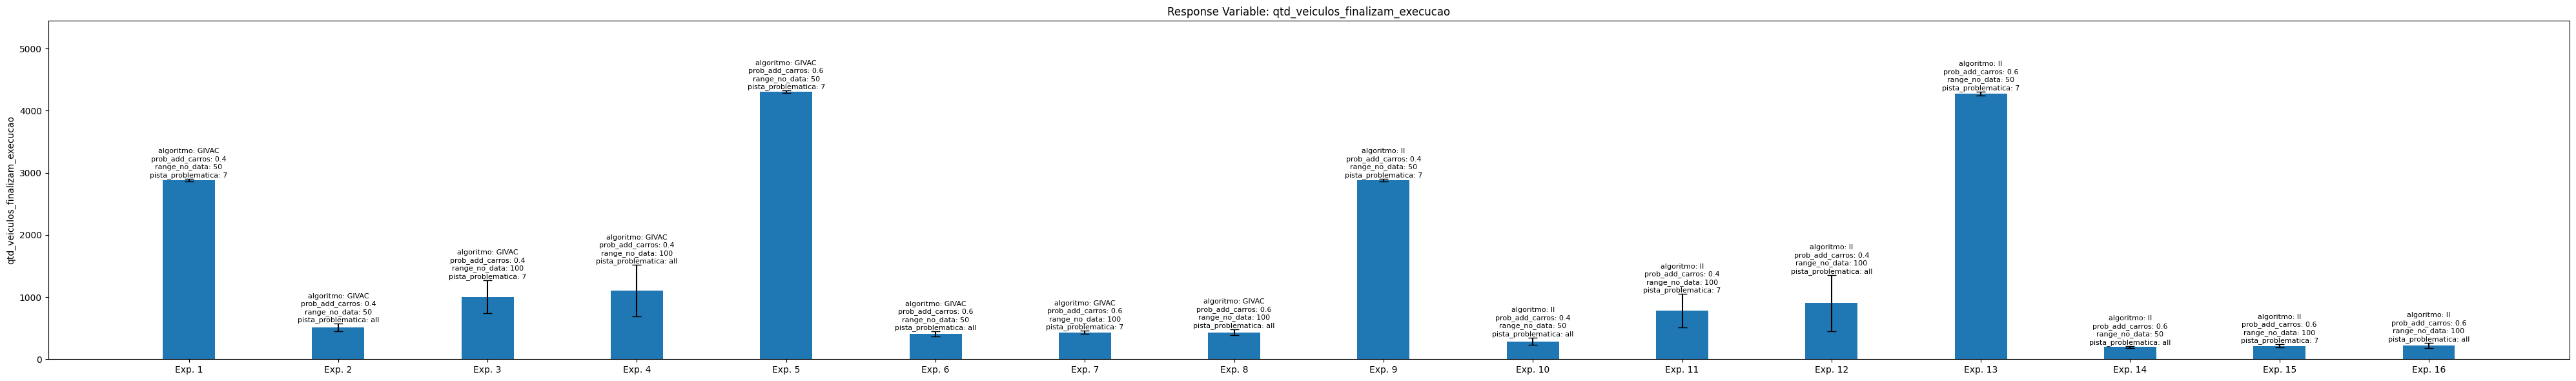

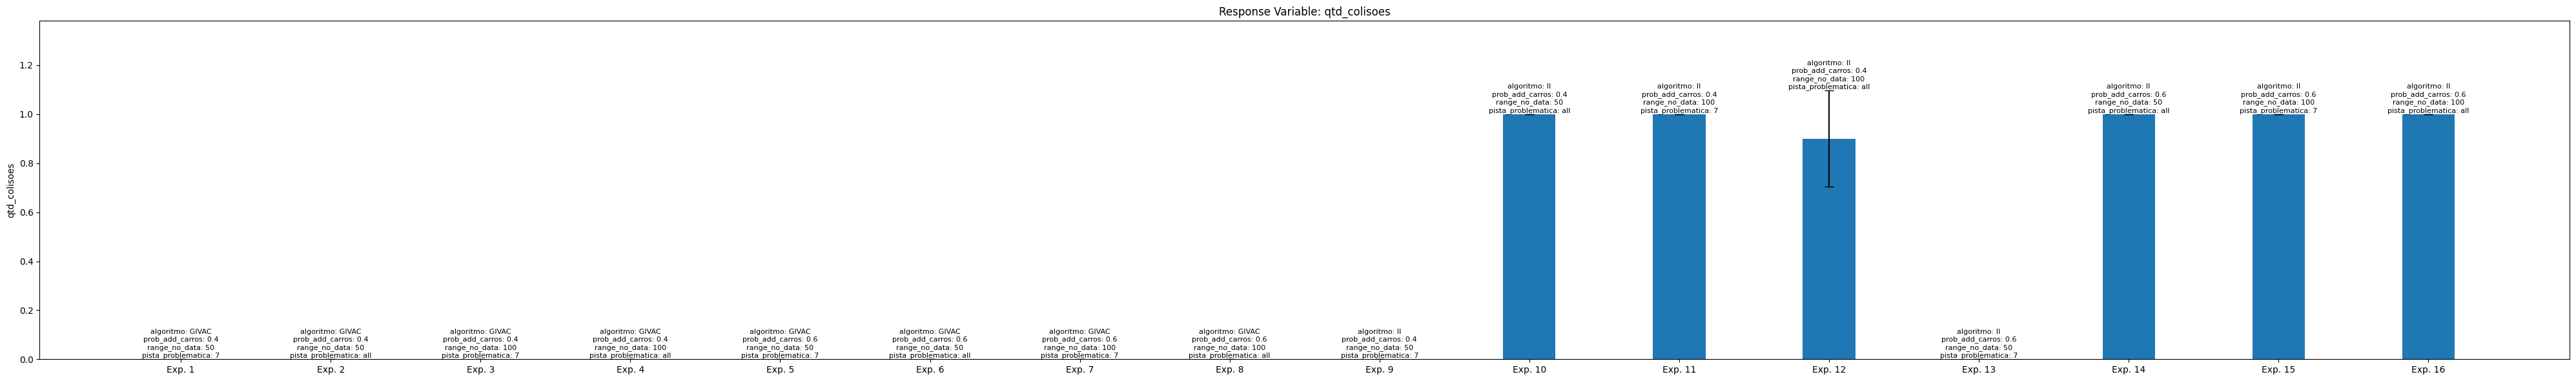

In [27]:
n_cols = 4
# Adjusting the bar width, if necessary
width = 0.35

for var_name in response_vars_names:
    # Increasing the chart height to accommodate labels
    plt.figure(figsize=(10 * n_cols, 6))  # Increasing the second value in figsize to increase the chart height
    
    n_experiments = len(experiment_settings_real_df)  # Number of experiments
    ind = np.arange(n_experiments)  # Indices for the experiments for bar positioning
    
    # Plotting the data from the real experiment settings
    bars = plt.bar(ind, experiment_settings_real_df[var_name],yerr=experiment_settings_real_df[var_name+"_err"],capsize=5,width= width, label='Experiments')
    # for i, (x_val, y_val, yerr_val) in enumerate(zip(grouped[column_x], grouped[(var, 'mean')], grouped[(var, 'mean_error')])):
    # plt.bar(x_val, y_val, yerr=yerr_val, color=colors[group_labels[i]], capsize=5)
    
    plt.title(f'Response Variable: {var_name}')  # Chart title
    plt.ylabel(var_name)  # Y-axis label
    
    # Generating labels for each bar based on factor combinations
    exp_labels = ['Exp. ' + str(exp) for exp in experiment_settings_real_df['Exp']]
    plt.xticks(ind, exp_labels)
    
    # Adding labels above bars to show factor combinations
    for bar, label in zip(bars, experiment_settings_real_df.to_dict('records')):
        height = bar.get_height()
        comb_label = '\n'.join([f"{k}: {v}" for k, v in label.items() if k in factor_names])
        height_err_plus = label[var_name+"_err"]
        plt.text(bar.get_x() + bar.get_width() / 2, height+height_err_plus, comb_label, ha='center', va='bottom', rotation=0, fontsize=8)
    
    # Adjusting the Y-axis limits to ensure labels fit without being cut off
    plt.ylim(0, plt.ylim()[1] * 1.2)  # Increases the upper limit of the Y-axis by 20%

    plt.tight_layout()
    plt.savefig('plot/Experiment/{}.pdf'.format(var_name), format='pdf')
    plt.show()


### Gráfico 2

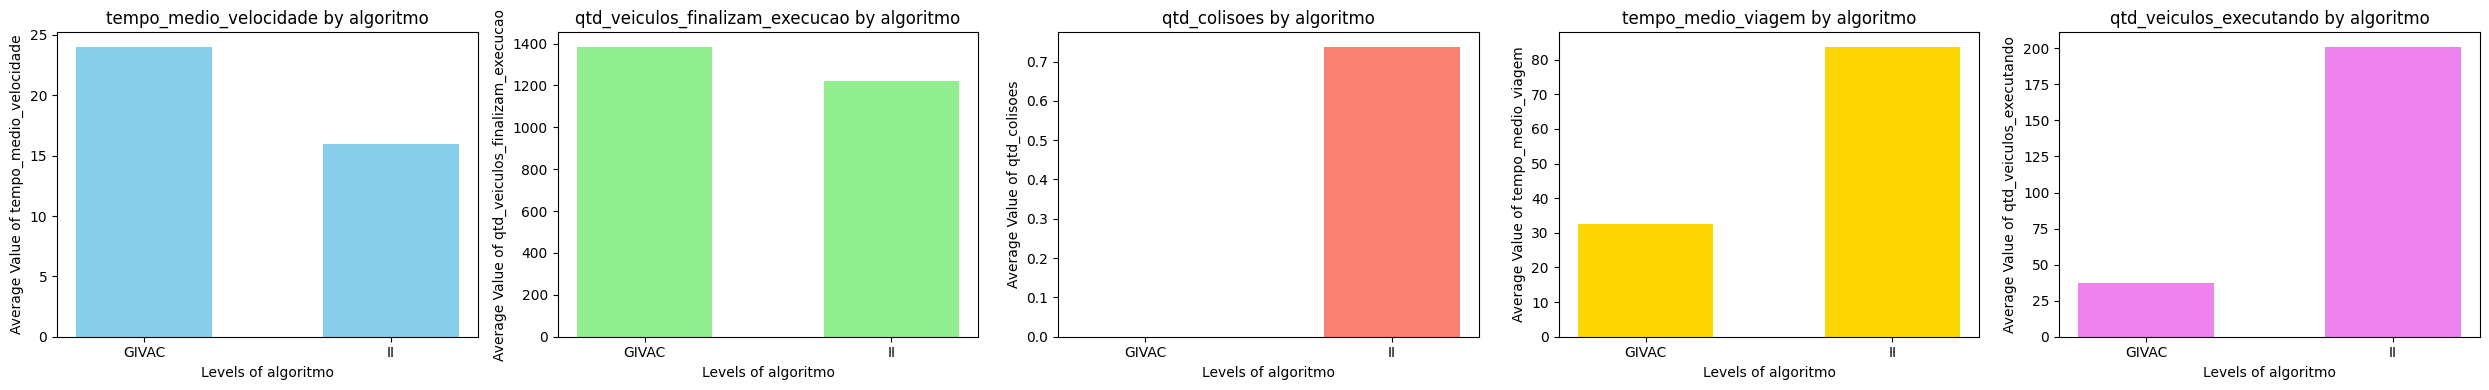

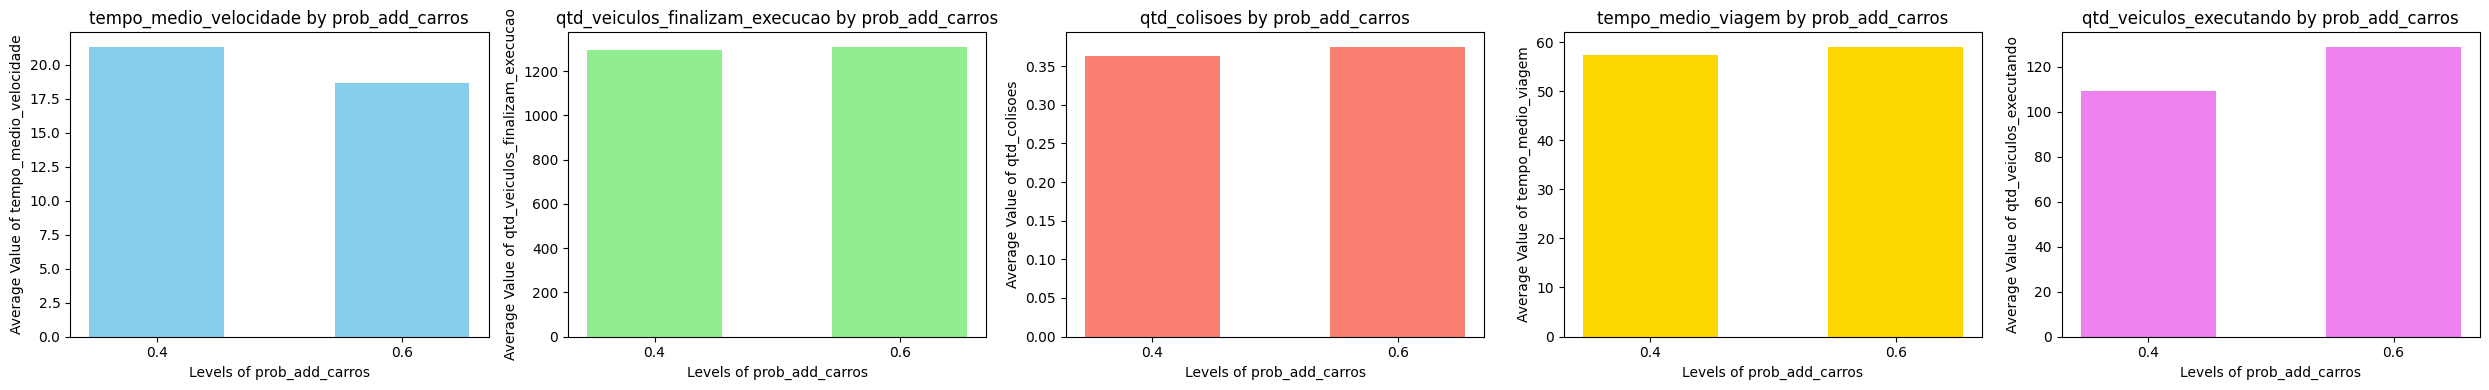

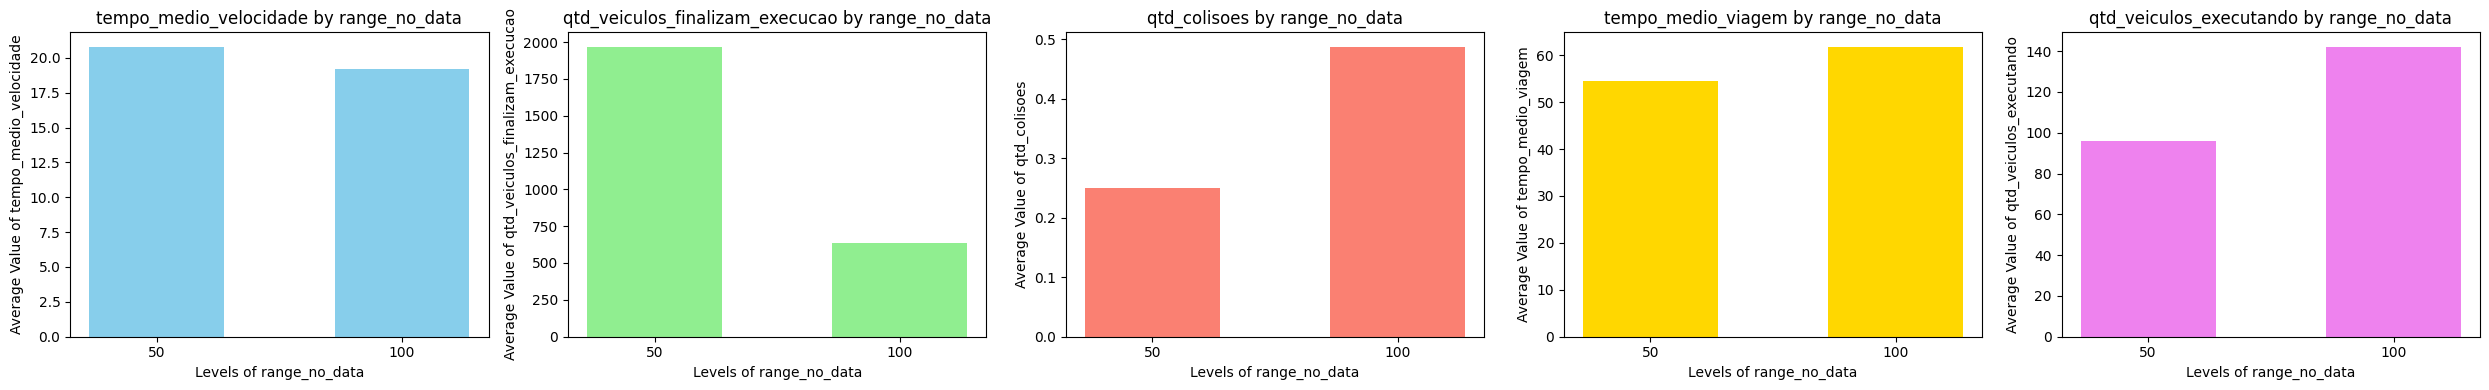

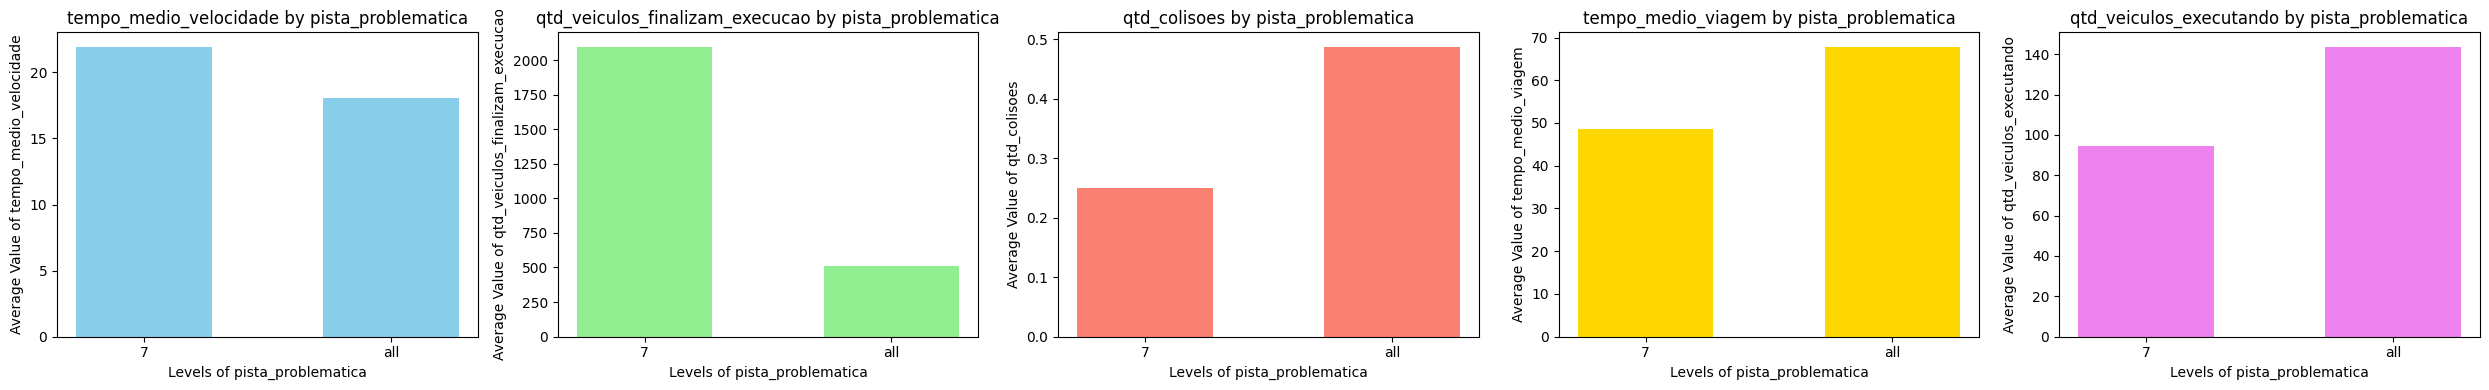

In [14]:
# Defining a color list for the response variables
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'violet', 'lightgrey', 'orange', 'cyan']

# Bar width
width = 0.55

# Iterating through each factor
for factor_name in factor_names:
    unique_levels = np.sort(experiment_settings_real_df[factor_name].unique())
    
    # Determining the number of subplots based on the number of response variables
    n_vars = len(response_vars_names)
    
    # The number of columns equals the number of response variables
    n_cols = n_vars
    # Always 1 row since we are fitting everything in a single horizontal line
    n_rows = 1
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4))  # Adjusting size as necessary
    axs = axs.flatten() if n_vars > 1 else [axs]  # Ensures axs is always iterable
    
    for i, var_name in enumerate(response_vars_names):
        mean_values = []
        # Preparing data for plotting
        for level in unique_levels:
            level_data = experiment_settings_real_df[experiment_settings_real_df[factor_name] == level]
            mean_val = level_data[var_name].mean()
            mean_values.append(mean_val)
        
        # Bar positions on the X-axis
        ind = np.arange(len(unique_levels))
        
        # Choosing the color for the current response variable
        bar_color = colors[i % len(colors)]
        
        # Plotting the bars
        axs[i].bar(ind, mean_values, width, label=f'{var_name}', color=bar_color)
        
        axs[i].set_title(f'{var_name} by {factor_name}')
        axs[i].set_xticks(ind)
        axs[i].set_xticklabels(unique_levels, rotation=0)  # Adjusting rotation for better visualization if needed
        axs[i].set_xlabel(f'Levels of {factor_name}')
        axs[i].set_ylabel(f'Average Value of {var_name}')
        #axs[i].legend()
    
    plt.tight_layout()
    plt.savefig('plot/Iterating_through_each_factor/{}-{}.pdf'.format(factor_name,var_name), format='pdf')
    plt.show()


### Tabela de conferência

In [15]:
# Displaying the tables
print("\nDesign of the Experiment with Coded Levels:")
display(experiment_design_df)
print("\nExperiment Settings with Real Levels:")
display(experiment_settings_real_df)

# Calculating the effects and SS for each response variable
results = calculate_effects_SS_dynamic(experiment_design_df, response_vars_names)

# Printing the formatted results
#print_formatted_results(results)


Design of the Experiment with Coded Levels:


Exp  algoritmo  prob_add_carros  range_no_data  pista_problematica  \
0     1         -1               -1             -1                  -1   
1     2         -1               -1             -1                   1   
2     3         -1               -1              1                  -1   
3     4         -1               -1              1                   1   
4     5         -1                1             -1                  -1   
5     6         -1                1             -1                   1   
6     7         -1                1              1                  -1   
7     8         -1                1              1                   1   
8     9          1               -1             -1                  -1   
9    10          1               -1             -1                   1   
10   11          1               -1              1                  -1   
11   12          1               -1              1                   1   
12   13          1                1             -1                  -1   
13   14          1                1             -1                   1   
14   15          1                1              1                  -1   
15   16          1                1              1                   1   

    tempo_medio_velocidade  qtd_veiculos_finalizam_execucao  qtd_colisoes  \
0                25.200962                           2884.8           0.0   
1                23.924625                            508.2           0.0   
2                24.989719                           1004.3           0.0   
3                24.666657                           1102.9           0.0   
4                25.007907                           4303.0           0.0   
5                21.754988                            406.6           0.0   
6                24.267770                            430.0           0.0   
7                22.327980                            433.3           0.0   
8                25.023263                           2884.6           0.0   
9                12.814630                            287.2           1.0   
10               17.396955                            779.2           1.0   
11               16.486228                            902.4           0.9   
12               21.740992                           4274.3           0.0   
13               10.883598                            199.4           1.0   
14               11.908889                            212.6           1.0   
15               11.569850                            221.3           1.0   

    tempo_medio_viagem  qtd_veiculos_executando  ...  algoritmo:range_no_data  \
0            31.527384                     29.5  ...                        1   
1            32.351144                     28.3  ...                        1   
2            31.167569                     27.8  ...                       -1   
3            32.551437                     27.4  ...                       -1   
4            31.784496                     43.1  ...                        1   
5            36.860845                     54.2  ...                        1   
6            30.471700                     41.4  ...                       -1   
7            34.219866                     44.5  ...                       -1   
8            31.795140                     29.7  ...                       -1   
9           122.843842                    249.3  ...                       -1   
10           89.904114                    252.9  ...                        1   
11           86.449435                    227.9  ...                        1   
12           46.053849                     71.8  ...                       -1   
13          103.113866                    261.4  ...                       -1   
14           95.455282                    258.8  ...                        1   
15           94.236901                    256.5  ...                        1   

    algoritmo:pista_problematica  prob_add_carros:range_n


Experiment Settings with Real Levels:


Exp algoritmo  prob_add_carros  range_no_data pista_problematica  \
0     1     GIVAC              0.4             50                  7   
1     2     GIVAC              0.4             50                all   
2     3     GIVAC              0.4            100                  7   
3     4     GIVAC              0.4            100                all   
4     5     GIVAC              0.6             50                  7   
5     6     GIVAC              0.6             50                all   
6     7     GIVAC              0.6            100                  7   
7     8     GIVAC              0.6            100                all   
8     9        II              0.4             50                  7   
9    10        II              0.4             50                all   
10   11        II              0.4            100                  7   
11   12        II              0.4            100                all   
12   13        II              0.6             50                  7   
13   14        II              0.6             50                all   
14   15        II              0.6            100                  7   
15   16        II              0.6            100                all   

    tempo_medio_velocidade  qtd_veiculos_finalizam_execucao  qtd_colisoes  \
0                25.200962                           2884.8           0.0   
1                23.924625                            508.2           0.0   
2                24.989719                           1004.3           0.0   
3                24.666657                           1102.9           0.0   
4                25.007907                           4303.0           0.0   
5                21.754988                            406.6           0.0   
6                24.267770                            430.0           0.0   
7                22.327980                            433.3           0.0   
8                25.023263                           2884.6           0.0   
9                12.814630                            287.2           1.0   
10               17.396955                            779.2           1.0   
11               16.486228                            902.4           0.9   
12               21.740992                           4274.3           0.0   
13               10.883598                            199.4           1.0   
14               11.908889                            212.6           1.0   
15               11.569850                            221.3           1.0   

    tempo_medio_viagem  qtd_veiculos_executando  ...  algoritmo:range_no_data  \
0            31.527384                     29.5  ...                        1   
1            32.351144                     28.3  ...                        1   
2            31.167569                     27.8  ...                       -1   
3            32.551437                     27.4  ...                       -1   
4            31.784496                     43.1  ...                        1   
5            36.860845                     54.2  ...                        1   
6            30.471700                     41.4  ...                       -1   
7            34.219866                     44.5  ...                       -1   
8            31.795140                     29.7  ...                       -1   
9           122.843842                    249.3  ...                       -1   
10           89.904114                    252.9  ...                        1   
11           86.449435                    227.9  ...                        1   
12           46.053849                     71.8  ...                       -1   
13          103.113866                    261.4  ...                       -1   
14           95.455282                    258.8  ...                        1   
15           94.236901                    256.5  ...                        1   

    algoritmo:pista_problematica  prob_add_carros:range_no_data  \
0                       

### Gráfico 4

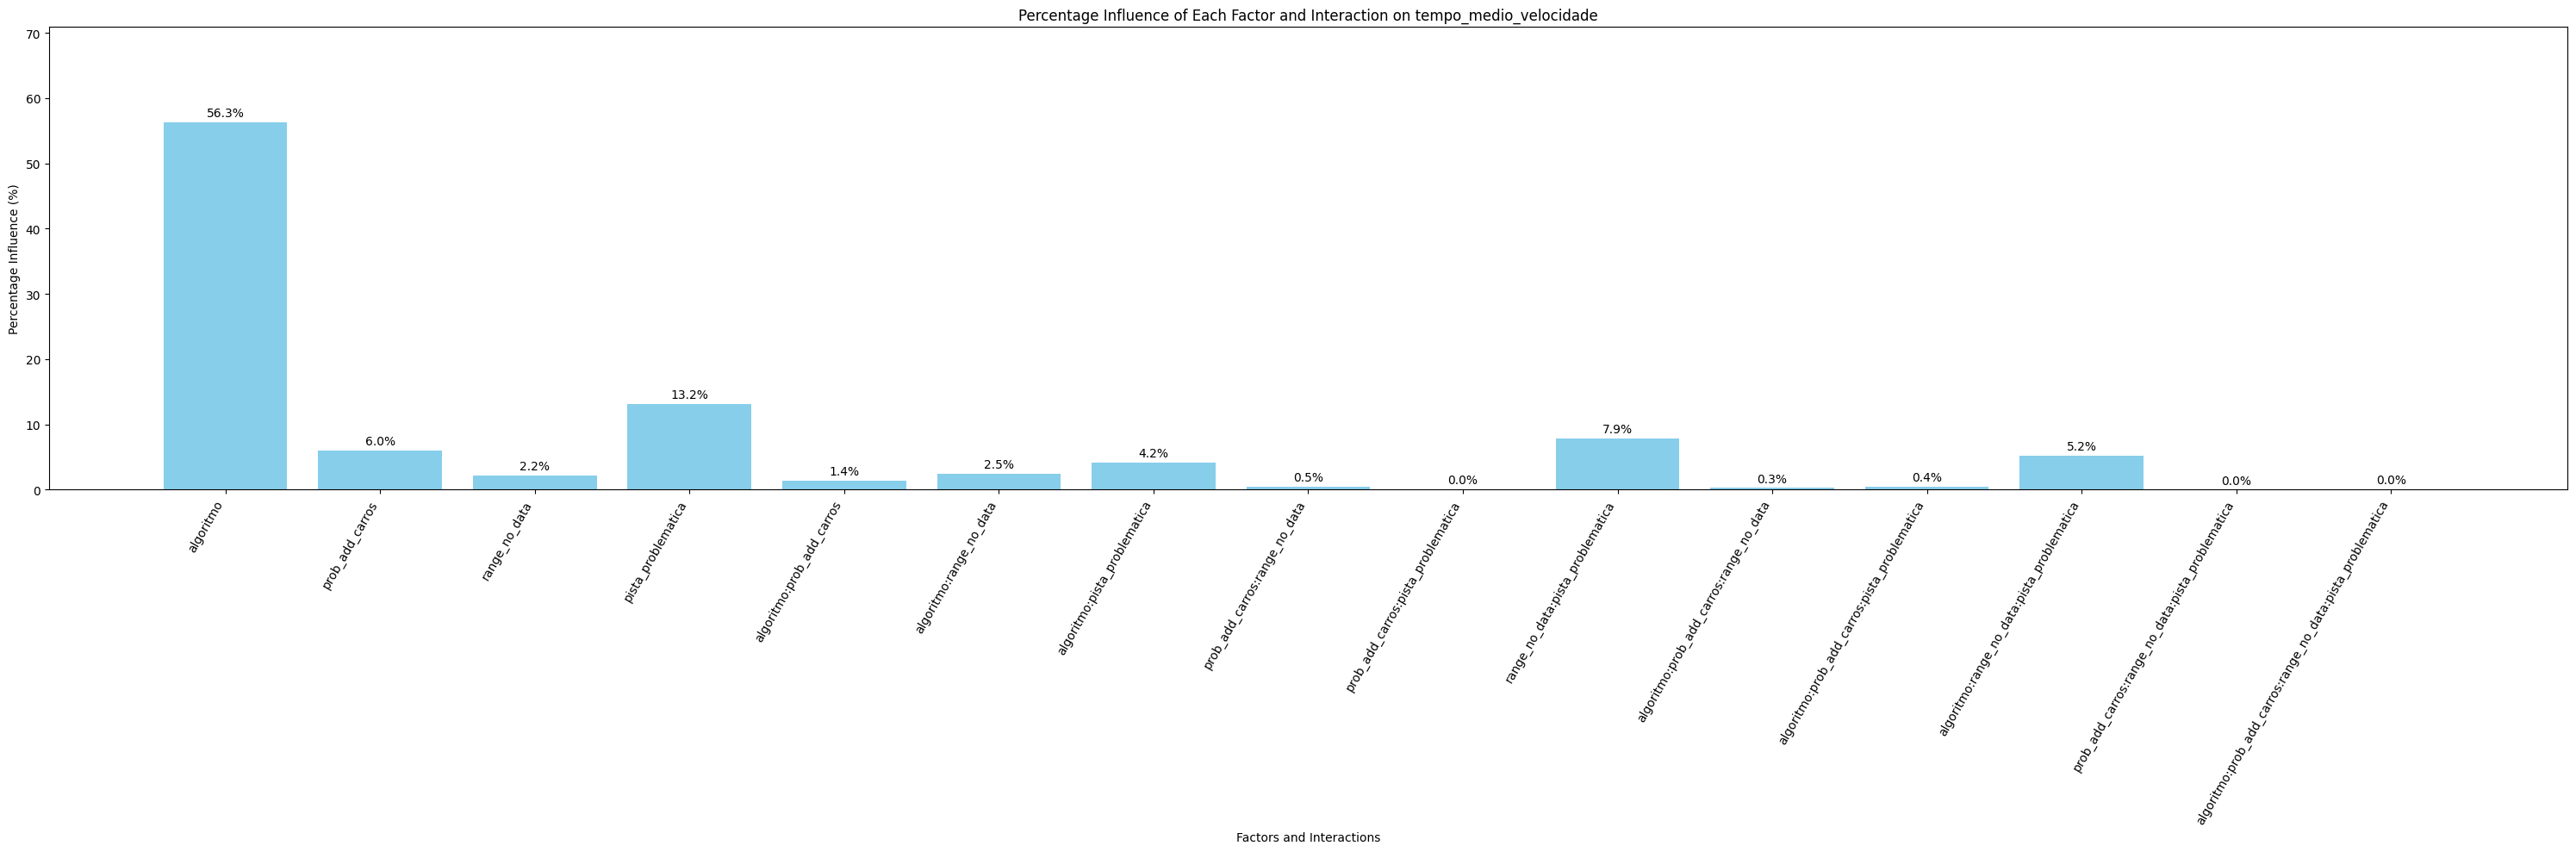

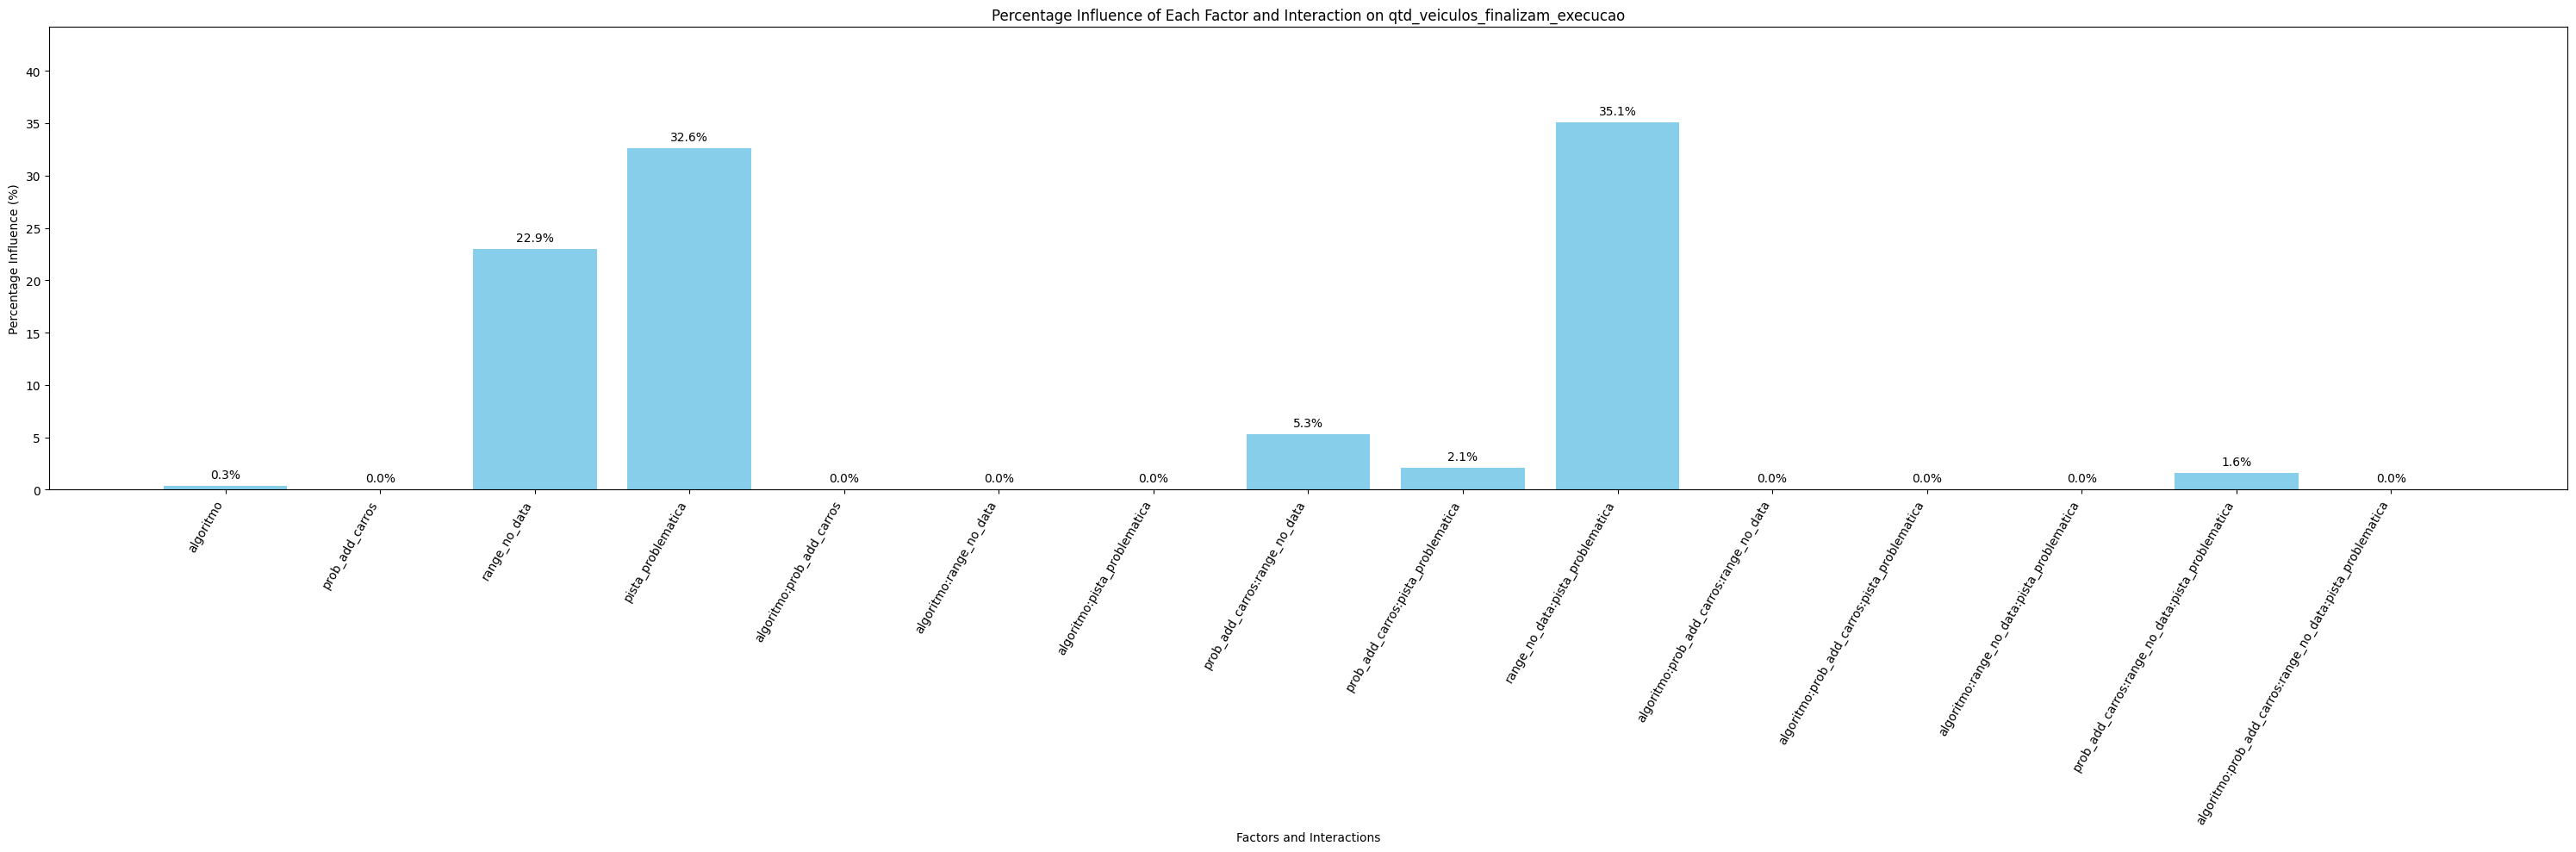

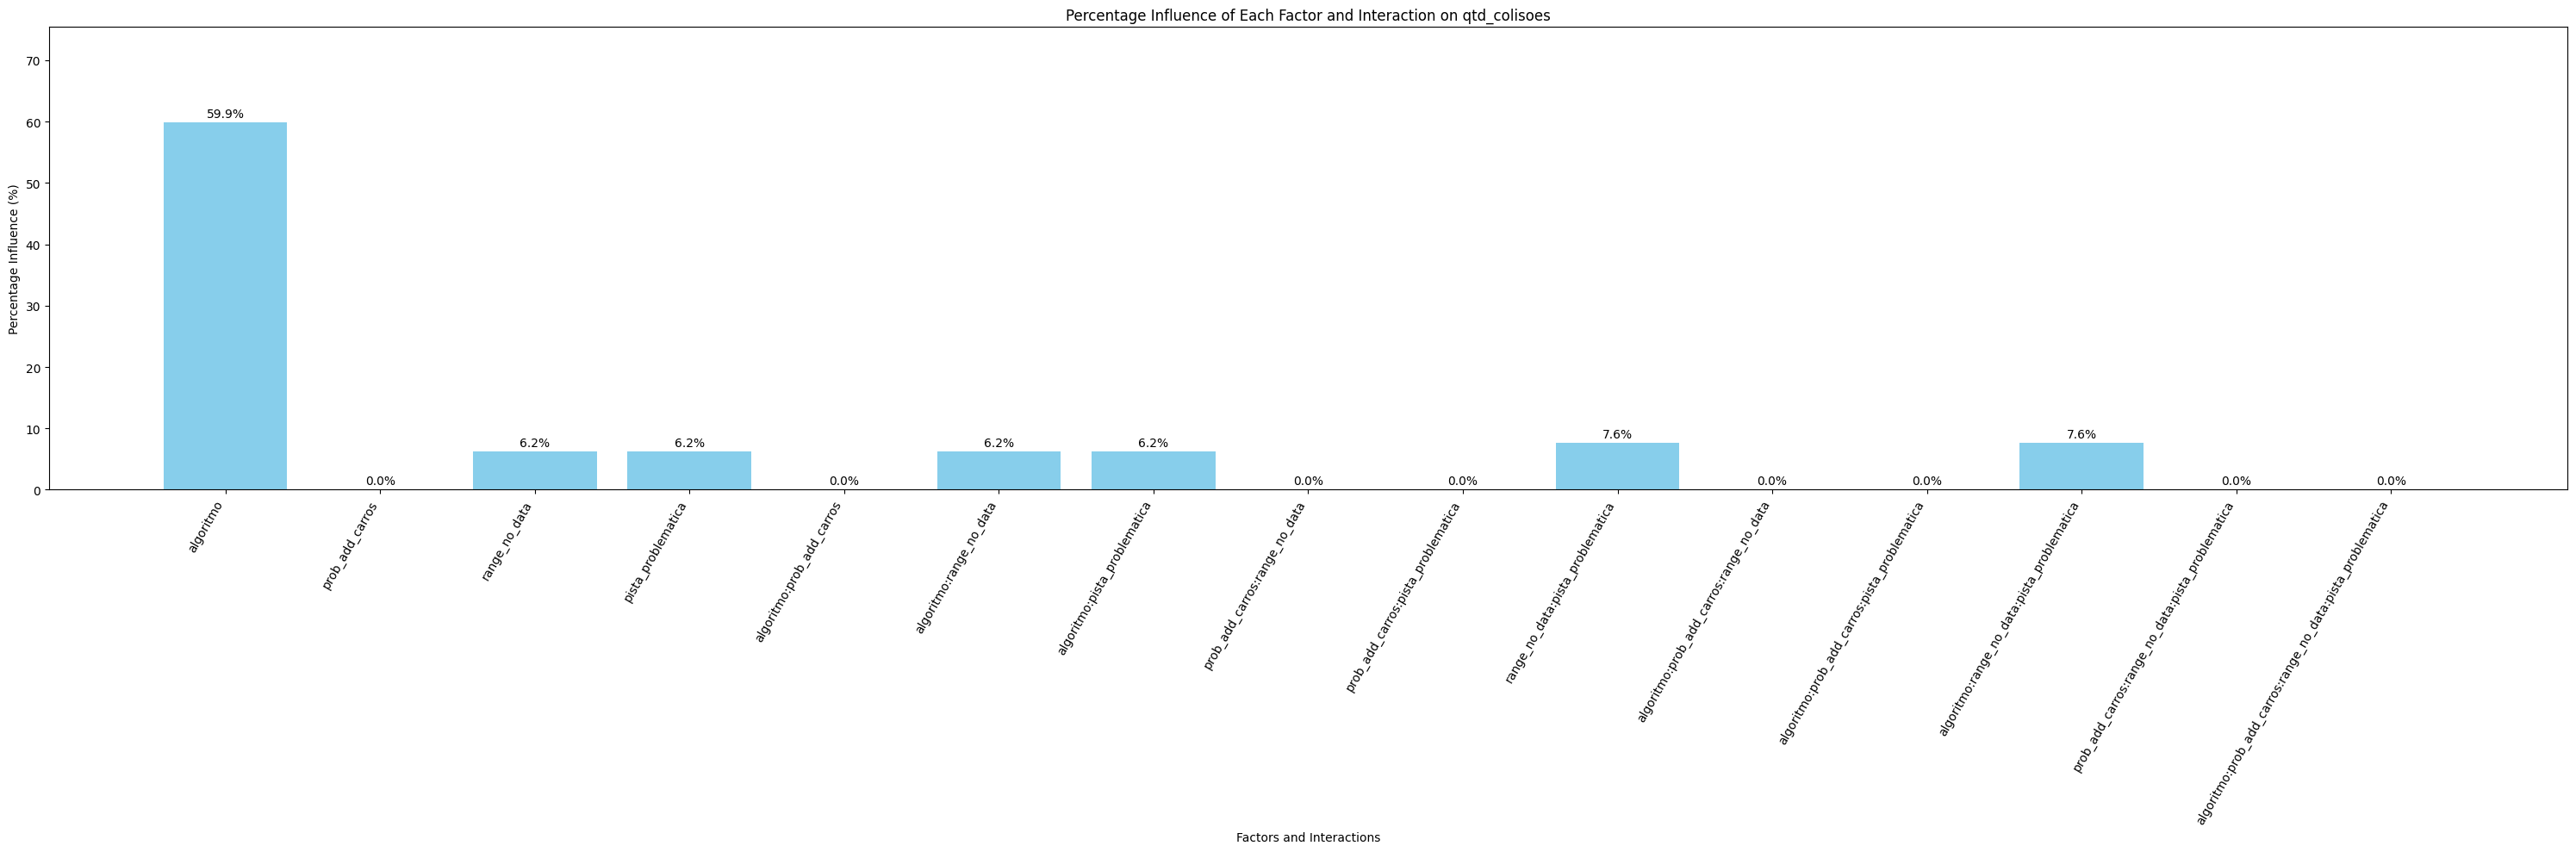

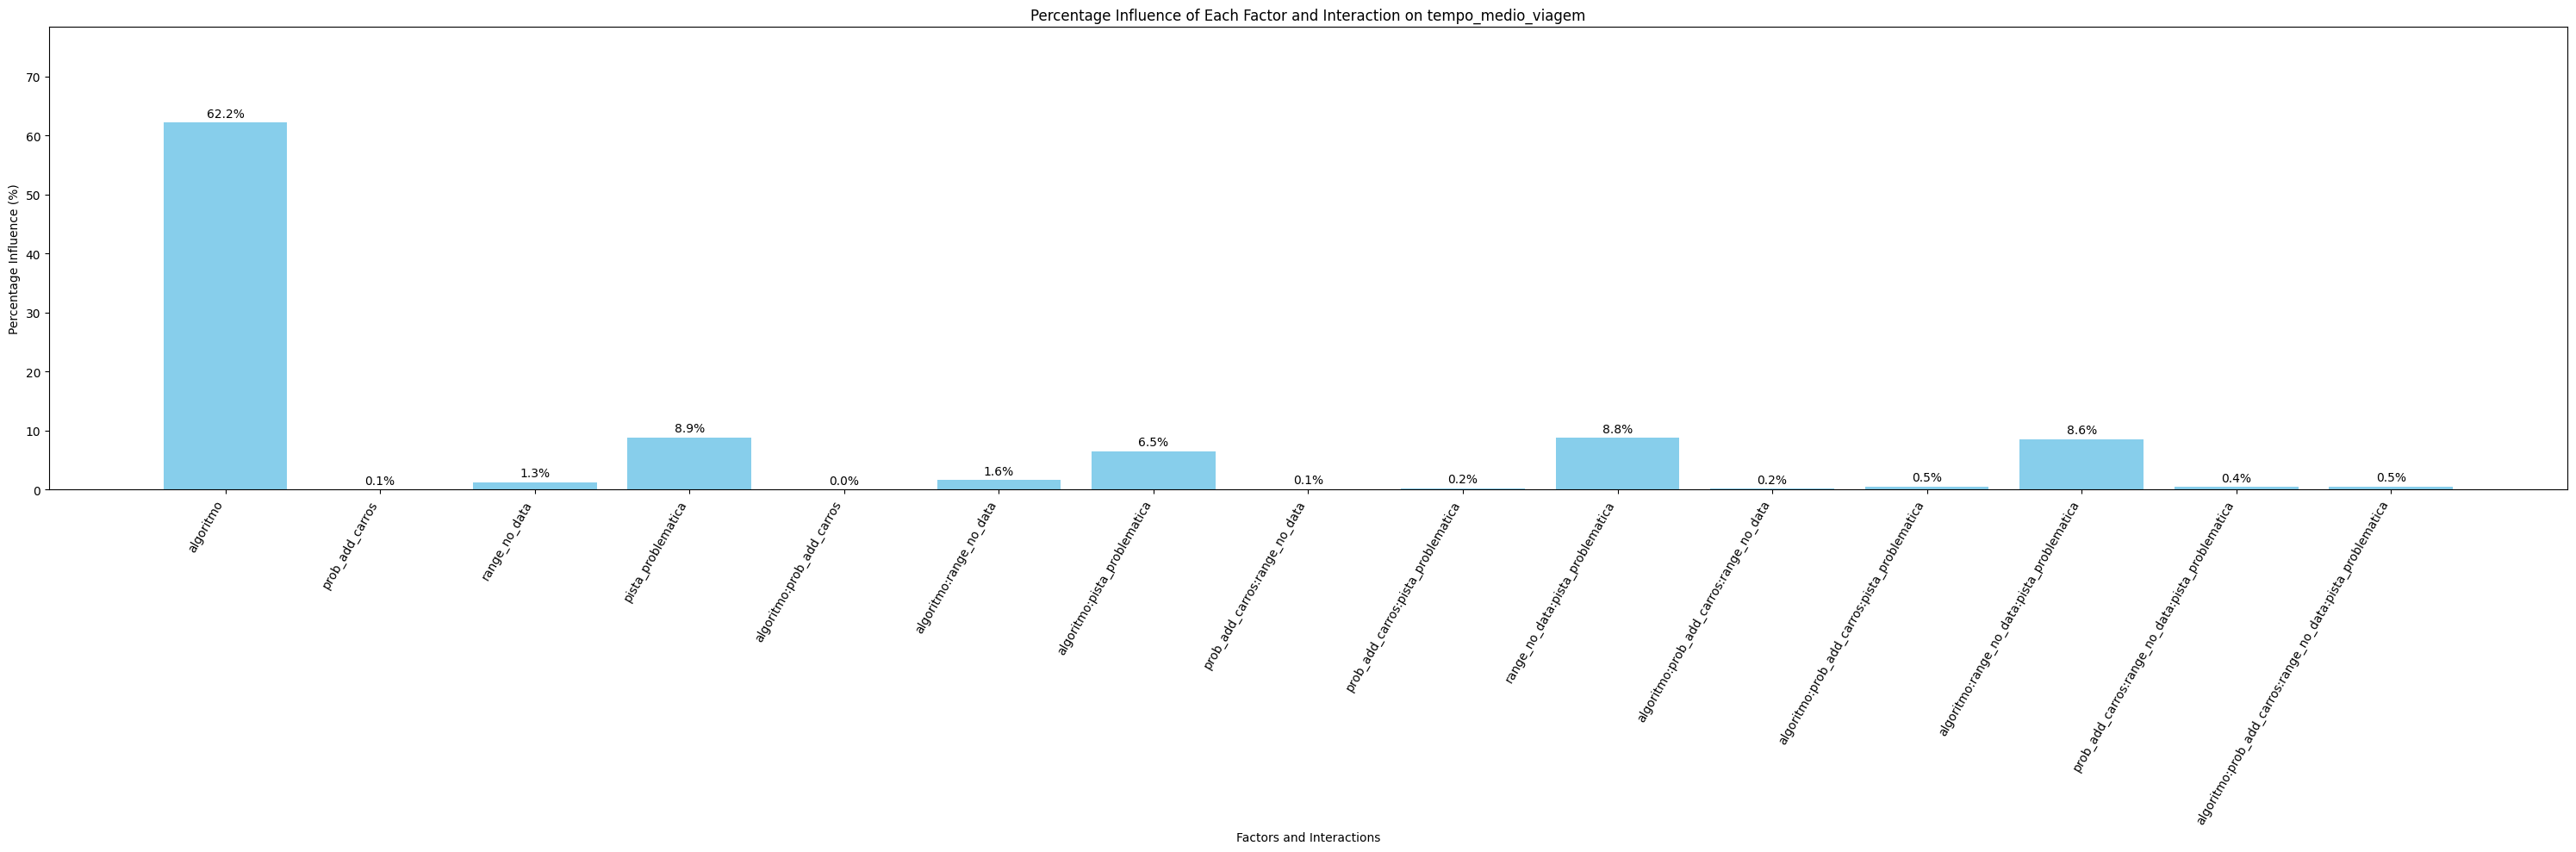

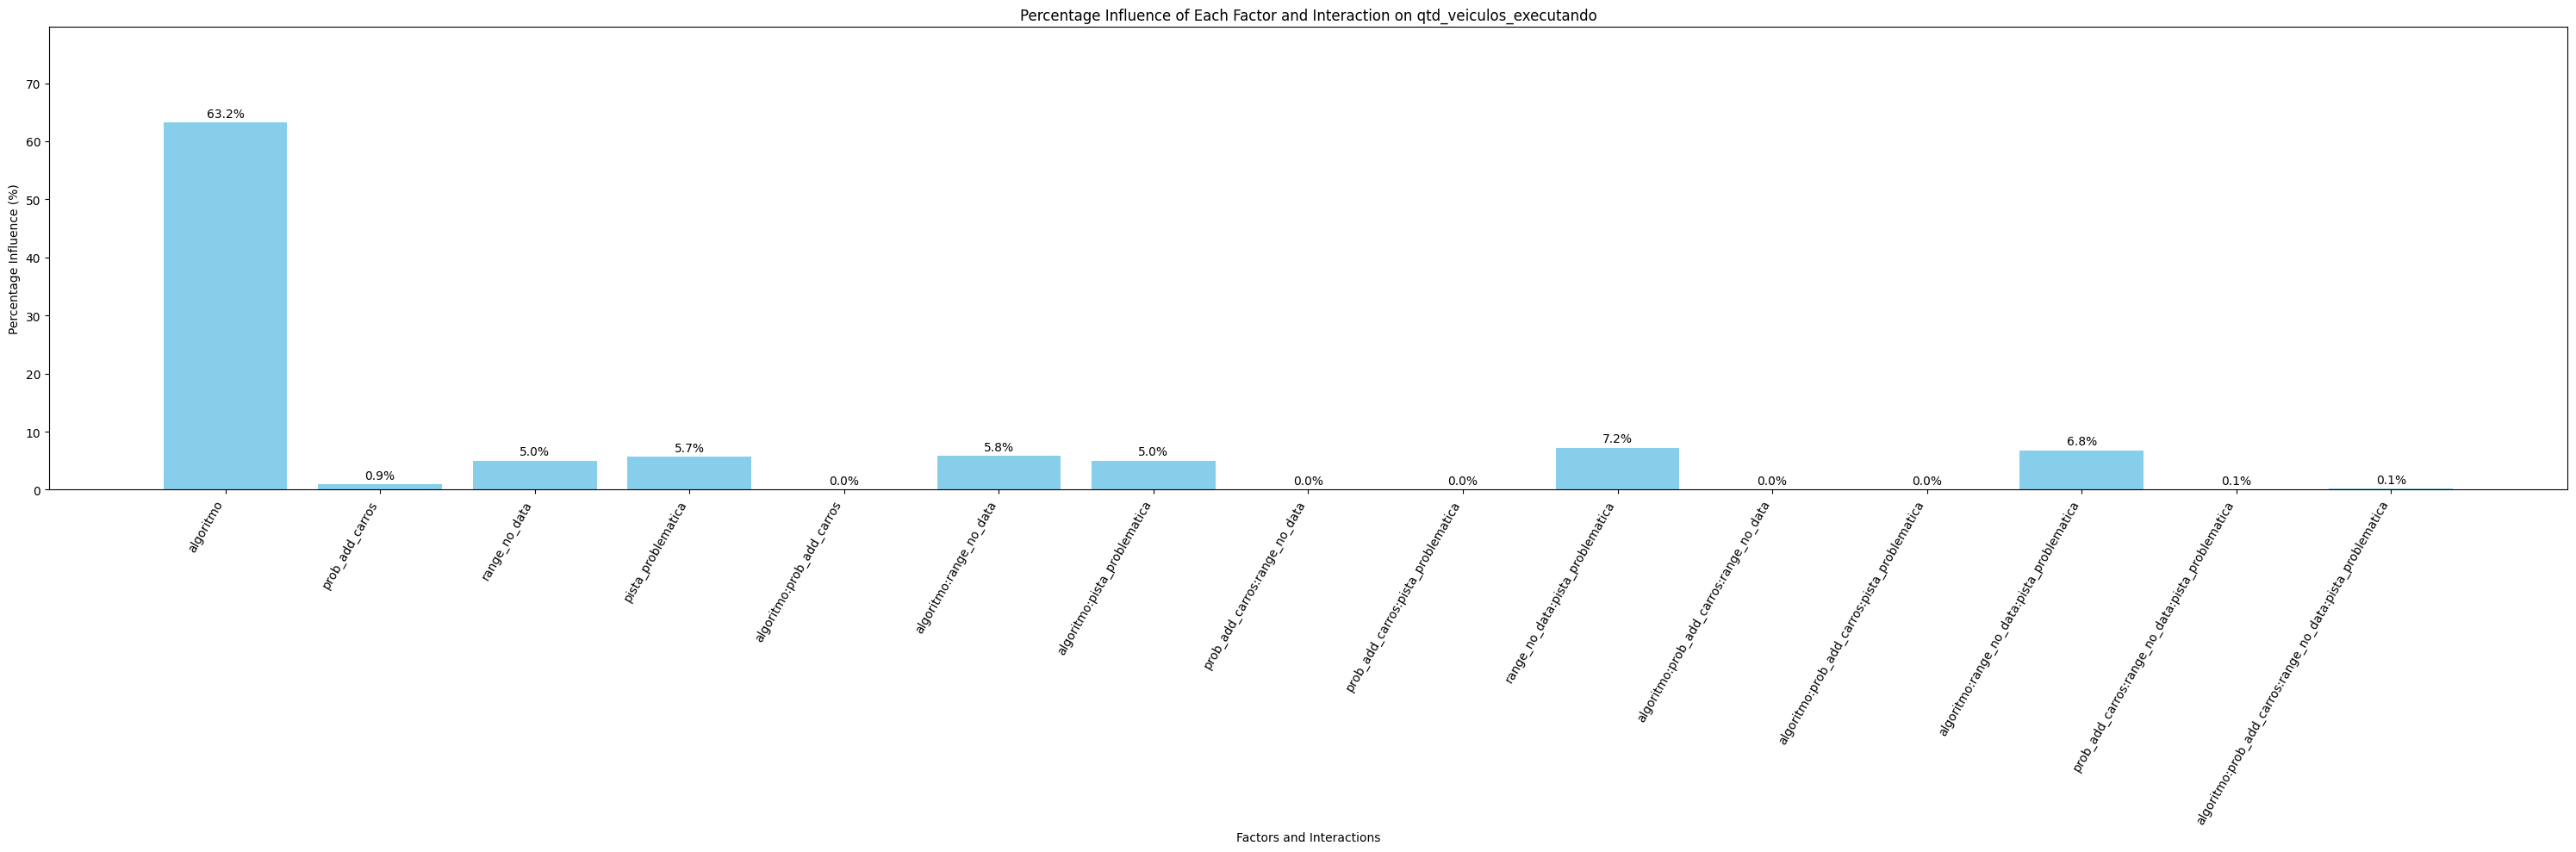

In [16]:
# Adapted function to plot formatted results
def plot_formatted_results(results):
    for response_var_name, (effects, SS, SST) in results.items():
        # Organizing data for plotting
        names = list(effects.keys())
        influences = [(ss / SST) * 100 for ss in SS.values()]

        # Creating the plot
        plt.figure(figsize=(30, 10))
        plt.bar(names, influences, color='skyblue')
        plt.title(f"Percentage Influence of Each Factor and Interaction on {response_var_name}")
        plt.ylabel('Percentage Influence (%)')
        # Adjusting the y-axis limits to ensure labels fit without cutting off
        plt.ylim(0, plt.ylim()[1] * 1.2)  # Increase the upper y-axis limit by 20%
        plt.xlabel('Factors and Interactions')
        plt.xticks(rotation=60, ha="right")
        plt.tight_layout()

        # Adding percentage labels above bars
        for i, influence in enumerate(influences):
            plt.text(i, influence + 0.5, f"{influence:.1f}%", ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig('plot/Influences/{}.pdf'.format(response_var_name), format='pdf')
        plt.show()

# Assuming 'results' has been previously calculated by the provided code
# results = calculate_effects_SS_dynamic(experiment_design_df, response_vars_names)
# Printing formatted results
# print_formatted_results(results)
# Calling the adapted function to plot the results
plot_formatted_results(results)


### Gráfico 5

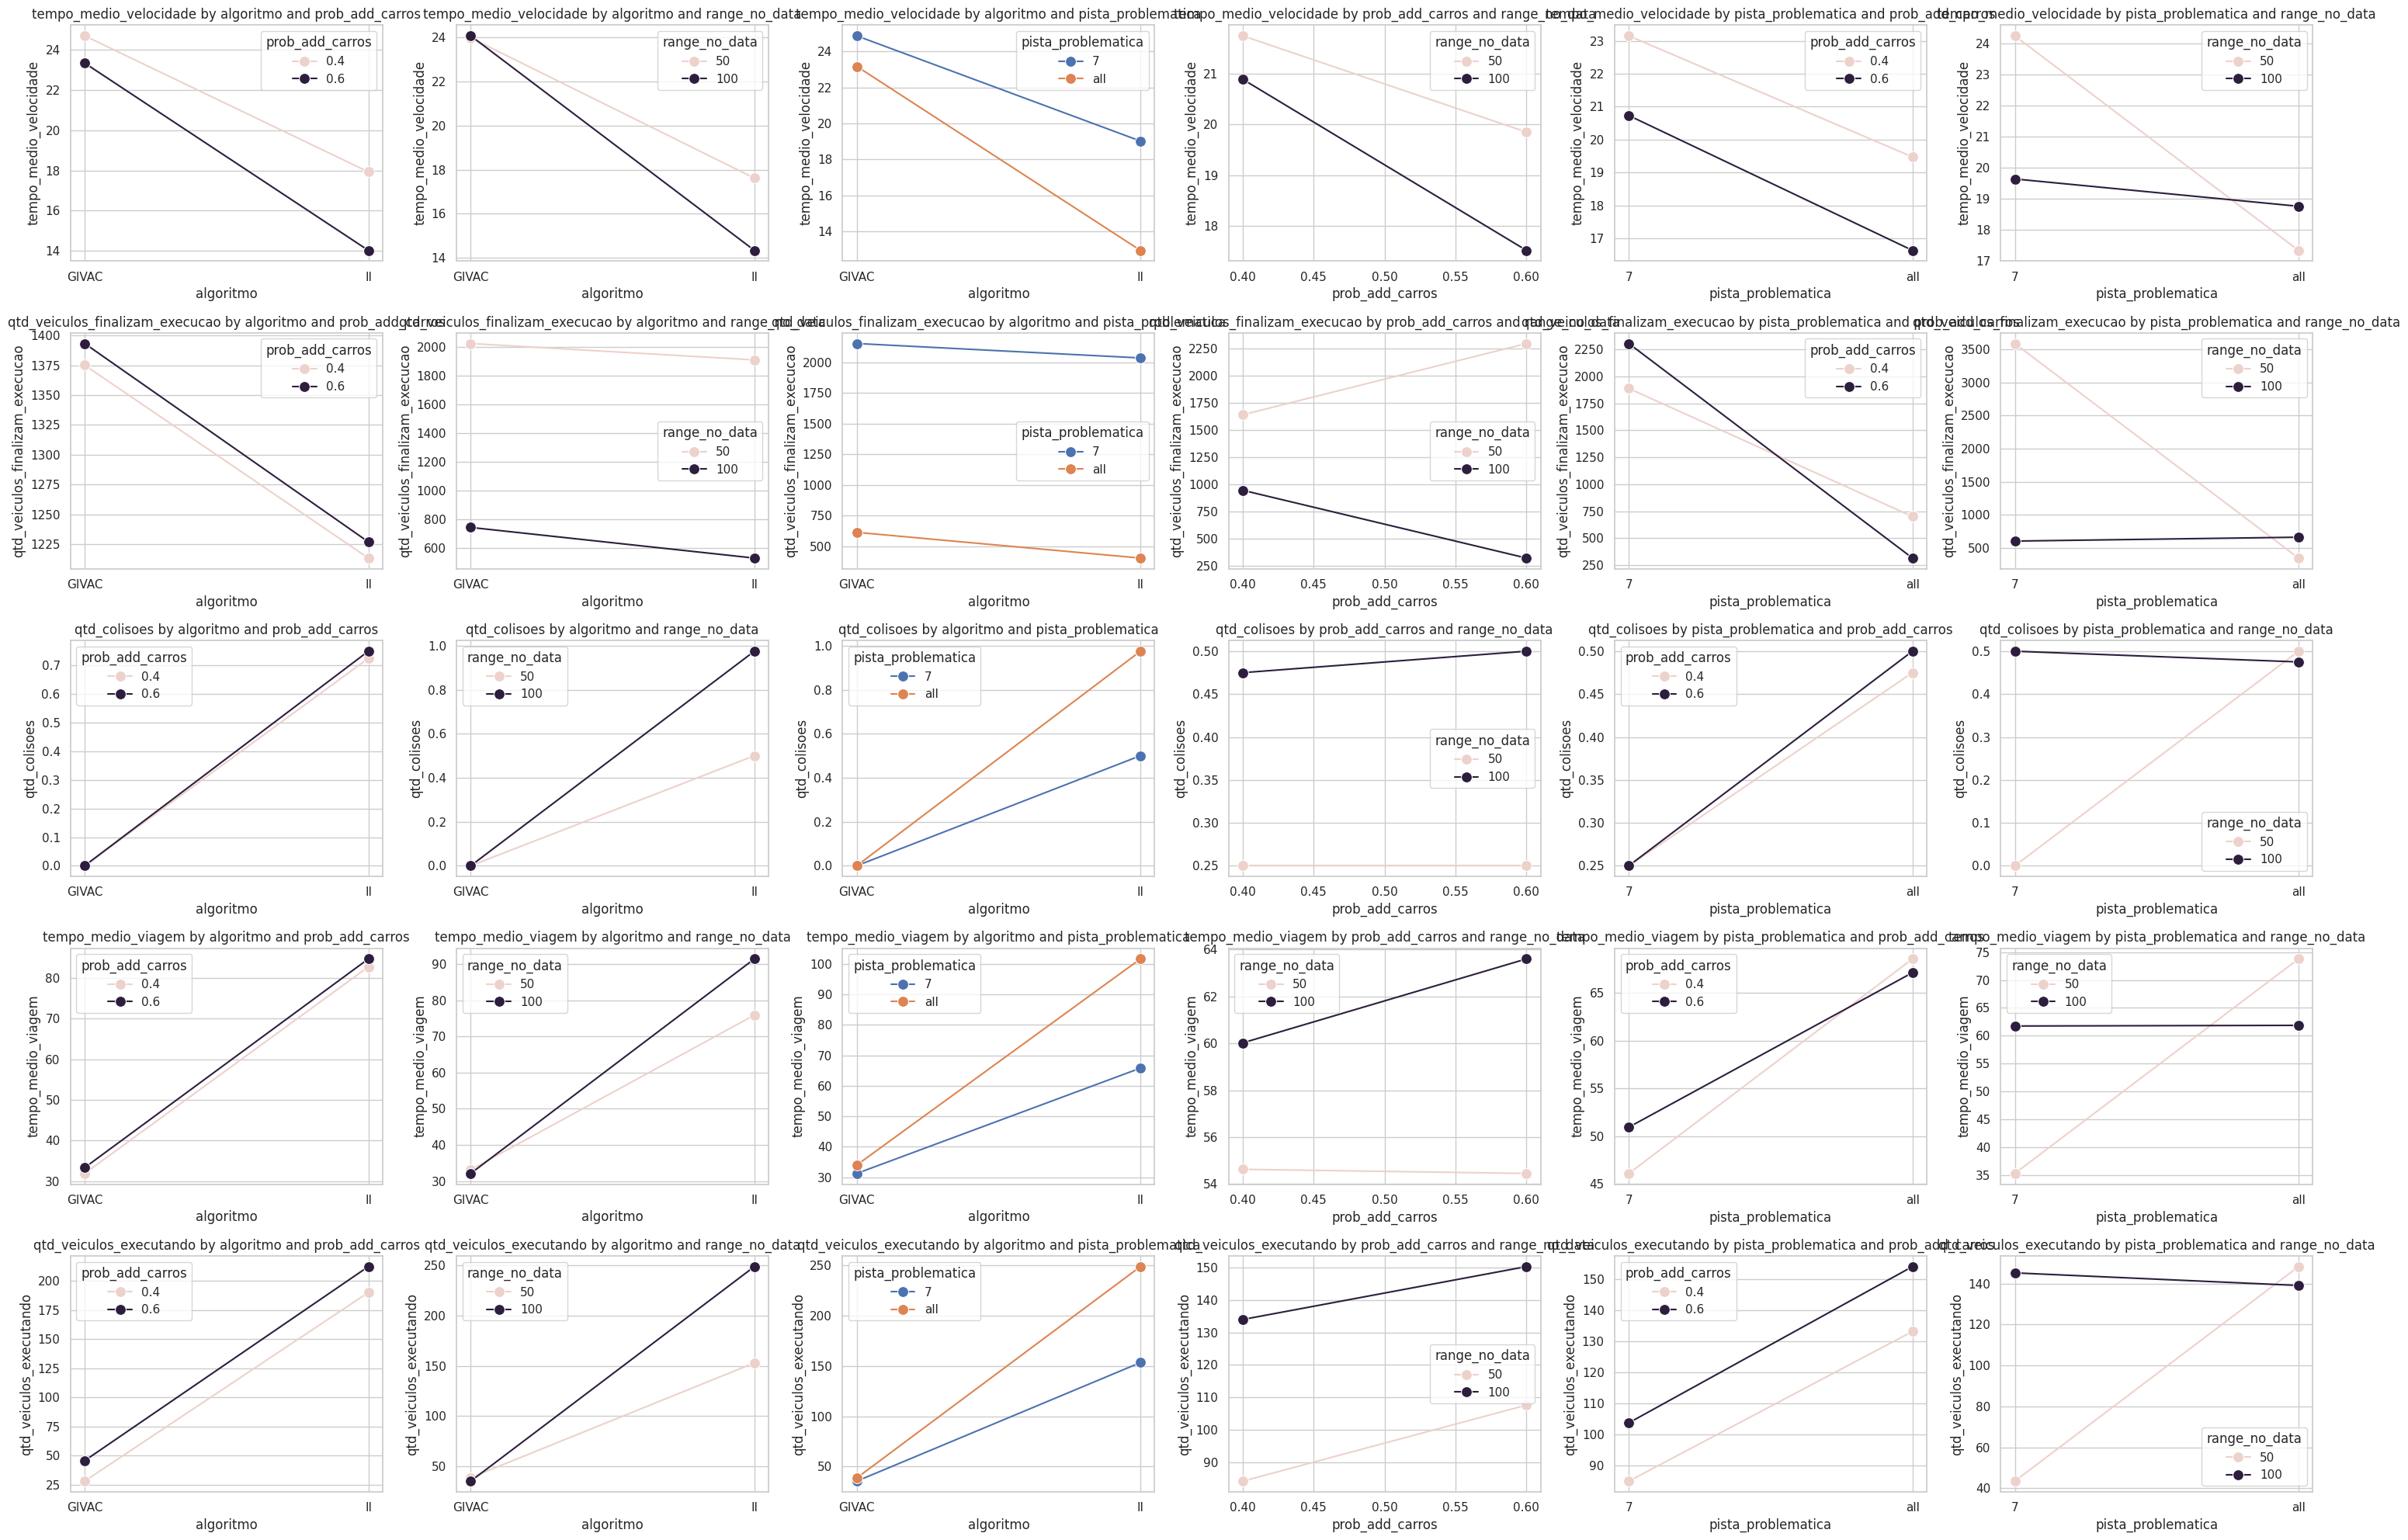

In [17]:
def plot_interaction_matrix_subplot(df, response_vars_names, factor_names):
    sns.set(style="whitegrid")
    
    # Determining the number of subplots needed based on the number of factor combinations
    num_factors = len(factor_names)
    num_combinations = num_factors * (num_factors - 1) // 2
    num_rows = len(response_vars_names)
    num_cols = max(1, num_combinations)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
    if num_rows == 1:
        axes = [axes]
    if num_cols == 1:
        axes = np.array([axes]).transpose()
    
    for i, response_var_name in enumerate(response_vars_names):
        ax_index = 0
        for factor1 in factor_names:
            for factor2 in factor_names:
                if factor1 < factor2:  # Ensuring we don't repeat combinations
                    # Filtering data for the two factors and the current response variable
                    plot_data = df[[factor1, factor2, response_var_name]].dropna()
                    
                    # Selecting the correct subplot
                    ax = axes[i, ax_index] if num_rows > 1 else axes[ax_index]
                    
                    # Creating the interaction plot
                    interaction_plot = sns.lineplot(x=factor1, y=response_var_name, hue=factor2, data=plot_data, 
                                                    marker='o', linestyle='-', markersize=10, errorbar=None, ax=ax)
                    interaction_plot.set_title(f'{response_var_name} by {factor1} and {factor2}')
                    interaction_plot.set_xlabel(factor1)
                    interaction_plot.set_ylabel(response_var_name)
                    ax.legend(title=factor2)
                    
                    ax_index += 1
                    
    plt.tight_layout()
    plt.savefig('plot/interaction_matrix_subplot.pdf', format='pdf')
    plt.show()

# Adjusted function call
plot_interaction_matrix_subplot(experiment_settings_real_df, response_vars_names, factor_names)


### Continuação ...

In [18]:
grouped.sort_values(by=['prob_add_carros', 'range_no_data','pista_problematica','algoritmo'],ascending=[True, True,True,False], inplace=True)

grouped.head(2)

algoritmo prob_add_carros range_no_data pista_problematica  stepLast       \
                                                                  mean  std   
8        II             0.4            50                  7  360001.0  0.0   
0     GIVAC             0.4            50                  7  360001.0  0.0   

  tempo_medio_viagem           tempo_medio_velocidade           qtd_colisoes  \
                mean       std                   mean       std         mean   
8          31.795140  0.116682              25.023263  0.063141          0.0   
0          31.527384  0.034876              25.200962  0.016127          0.0   

       total_veh_inseridos            qtd_veiculos_finalizam_execucao  \
   std                mean        std                            mean   
8  0.0              2914.3  37.049666                          2884.6   
0  0.0              2914.3  37.049666                          2884.8   

             qtd_veiculos_executando                        id  
         std                    mean       std                  
8  35.547152                    29.7  4.831609     II-0.4-50-7  
0  35.530269                    29.5  4.672615  GIVAC-0.4-50-7

#### Calculando o intervalo de confiança

In [19]:
# Usando a função norm.ppf() para obter o valor Z crítico
z = stats.norm.ppf(0.975)  # Retorna cerca de 1.96 para um intervalo de confiança de 95%

In [20]:
def calc_interval(grouped,var_resposta,n = 10,column_x = 'id', rotation = 0):
    for var in var_resposta:
        #Calculo do erro médio para o intervalo de confiança
        grouped[(var, 'mean_error')] = z * (grouped[(var, 'std')] / np.sqrt(n))
        plt.figure(figsize=(12, 6))
        group_labels = ['II' if id.startswith('II') else 'GIVAC' for id in grouped[column_x]]
        colors = {'II': 'lightblue', 'GIVAC': 'lightgreen'}  
        
        for i, (x_val, y_val, yerr_val) in enumerate(zip(grouped[column_x], grouped[(var, 'mean')], grouped[(var, 'mean_error')])):
            plt.bar(x_val, y_val, yerr=yerr_val, color=colors[group_labels[i]], capsize=5)
            
        # plt.bar(column_x, grouped[(var, 'mean')], yerr=grouped[(var, 'mean_error')], capsize=5,color='skyblue')
        plt.xticks(rotation=rotation)
        # plt.xlabel('Grupos')
        plt.ylabel(var)
        plt.title(f'Média e Intervalo de Confiança de 95% para {var}')
        plt.show()

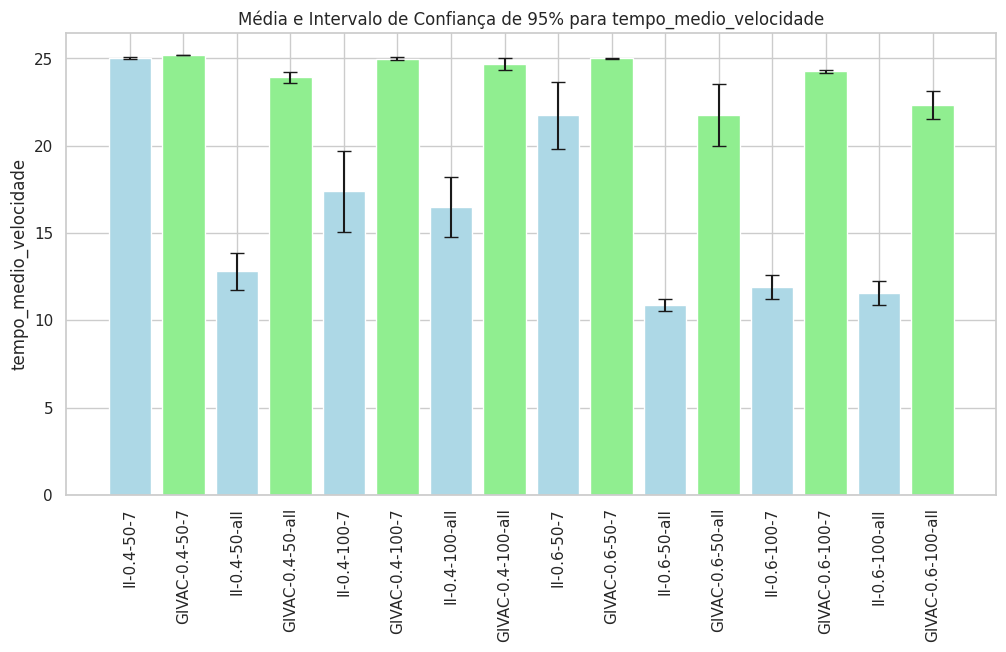

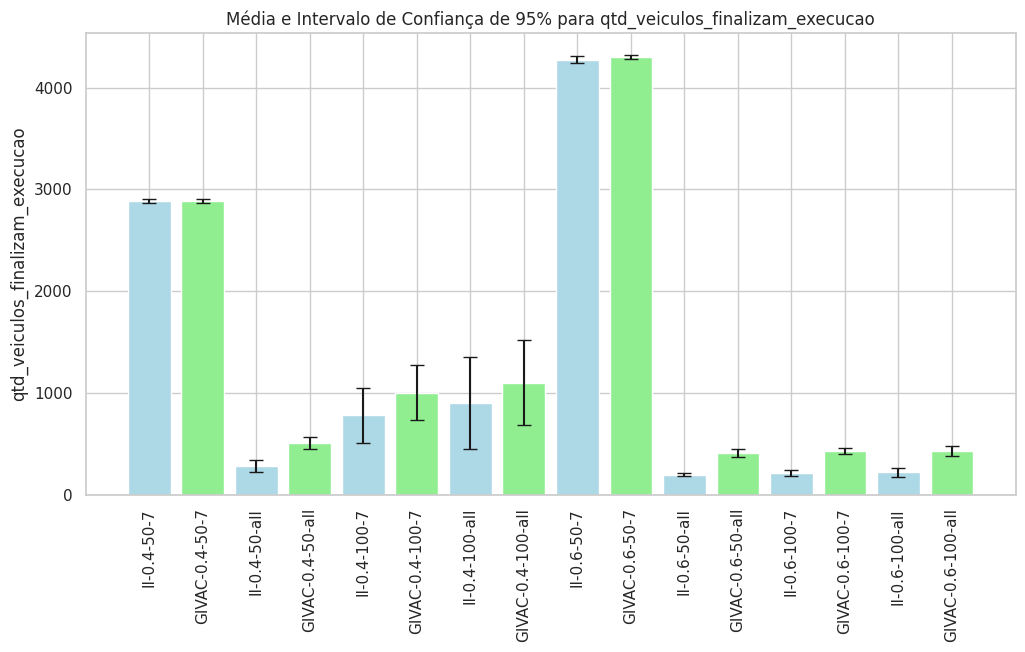

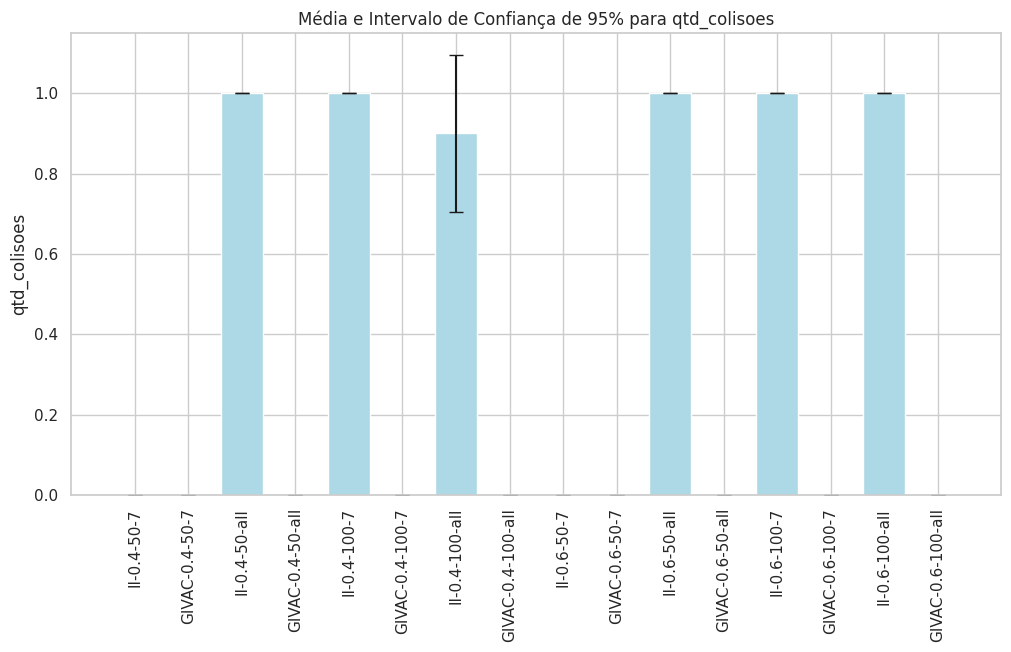

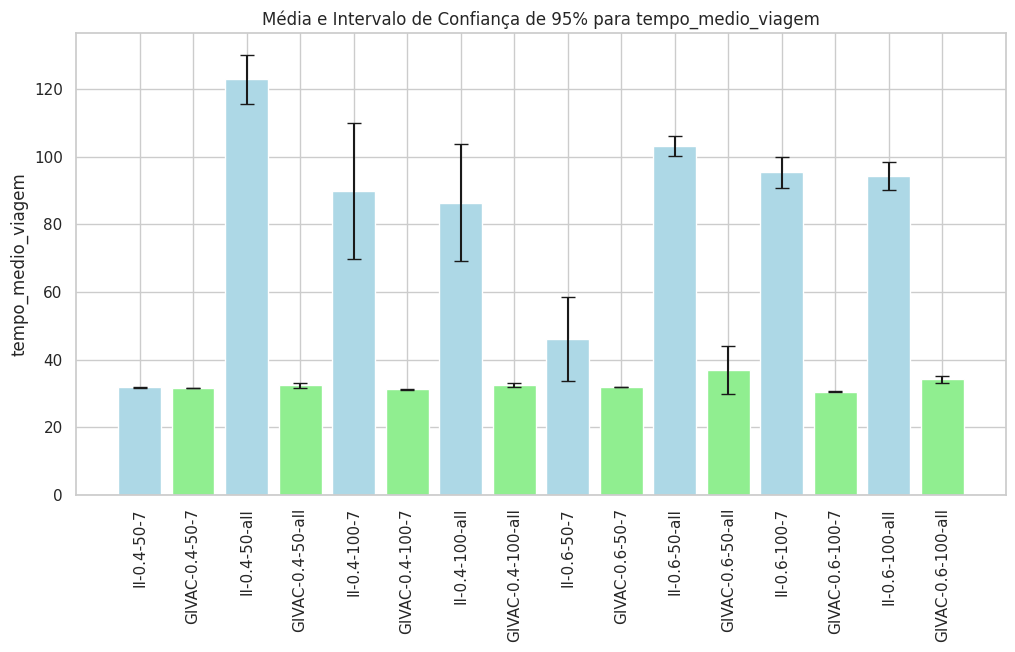

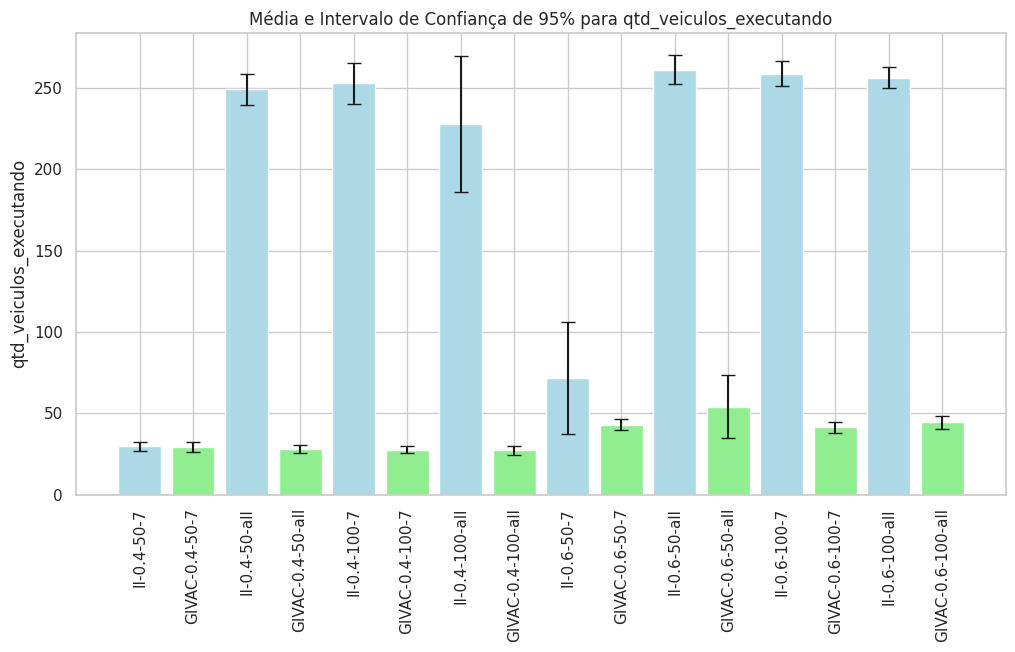

In [21]:
calc_interval(grouped,var_resposta, rotation = 90)

### Calculo Geral por algoritmo, para os 8 cenários e as 10 sementes

In [22]:
n_experiment = len(df.query("algoritmo == 'GIVAC'"))

In [23]:
lista_index.remove('algoritmo')
grouped = df.drop(columns=['seed','id']+lista_index).groupby('algoritmo').agg(['mean','std']).reset_index()
grouped.sort_values(by=['algoritmo'],ascending=[False], inplace=True)

grouped

algoritmo    stepLast                tempo_medio_viagem             \
                   mean            std               mean        std   
1        II  146506.125  133946.788178          83.731554  32.948908   
0     GIVAC  146506.125  133946.788178          32.616805   4.412721   

  tempo_medio_velocidade           qtd_colisoes           total_veh_inseridos  \
                    mean       std         mean       std                mean   
1              15.978051  5.309887       0.7375  0.442769           1421.1625   
0              24.017576  1.645733       0.0000  0.000000           1421.1625   

               qtd_veiculos_finalizam_execucao               \
           std                            mean          std   
1  1382.809436                       1220.1250  1466.262064   
0  1382.809436                       1384.1375  1383.501060   

  qtd_veiculos_executando             
                     mean        std  
1                201.0375  93.987939  
0                 37.0250  14.809315

#### Calculando o intervalo de confiança

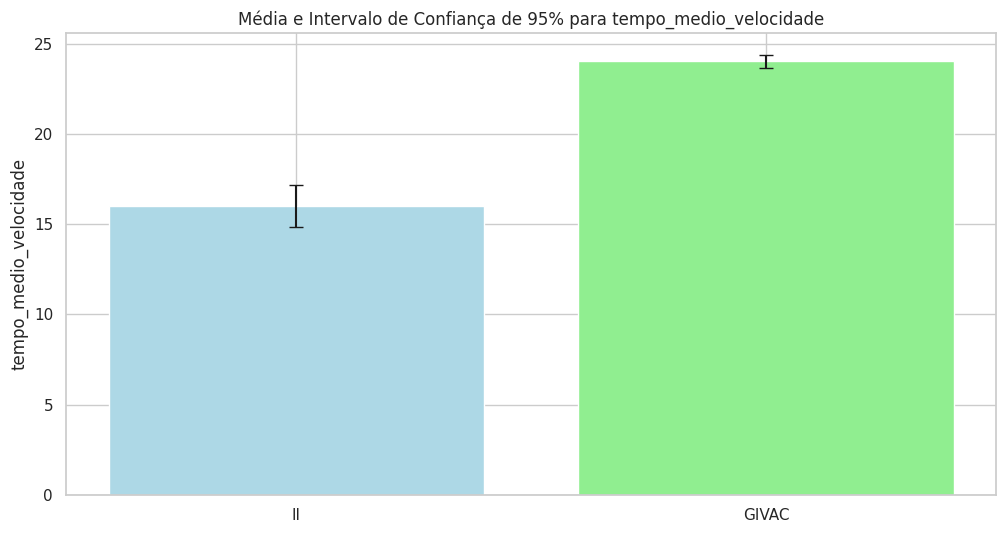

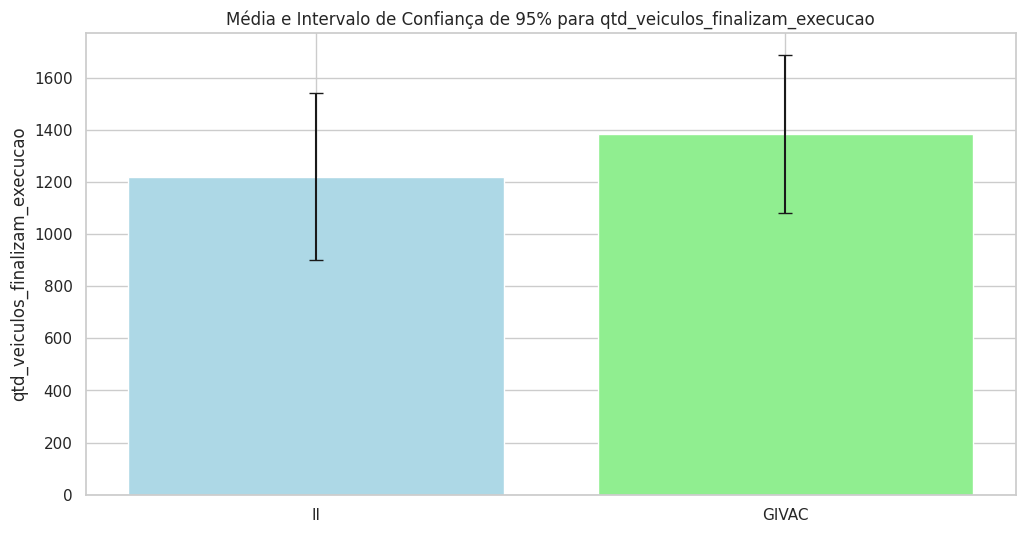

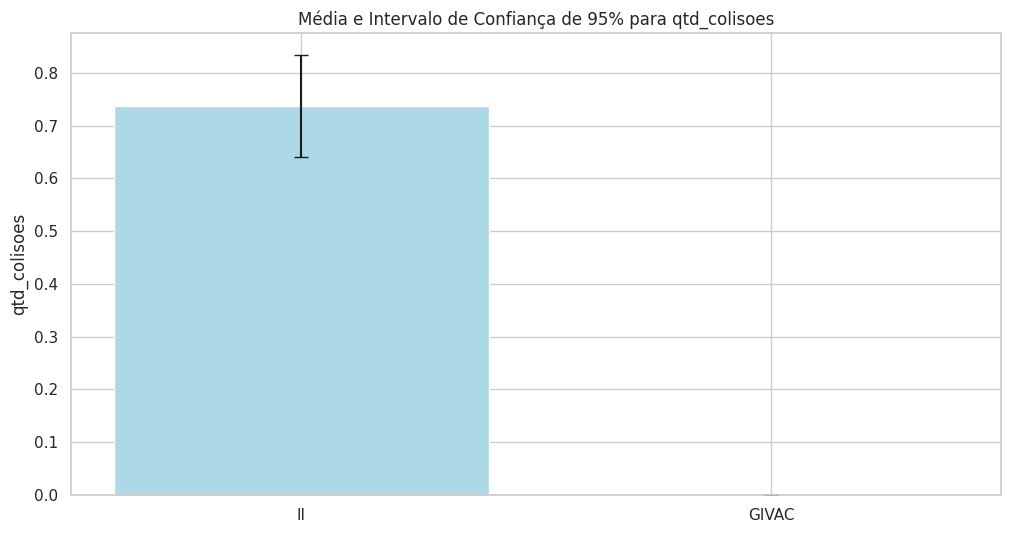

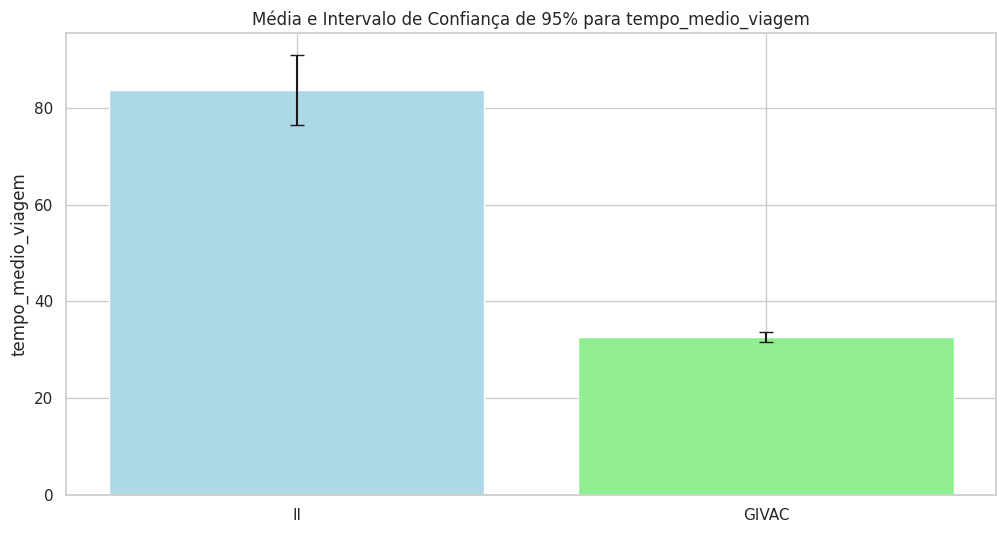

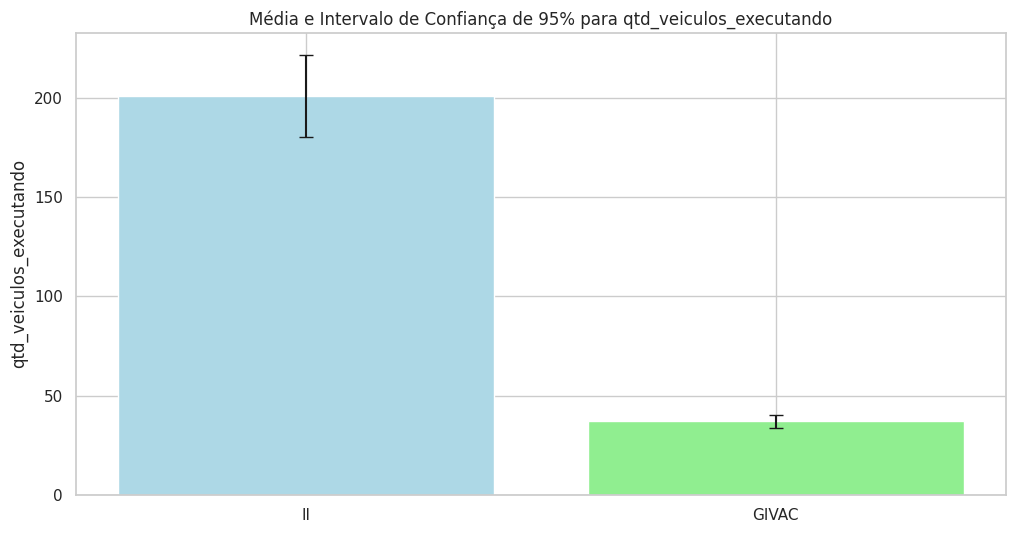

In [24]:
calc_interval(grouped,var_resposta,n=n_experiment,column_x = 'algoritmo', rotation = 0)

### Calculo em relação ao Range sem dados

In [25]:
var = 'range_no_data'
n_experiment = len(df.query("algoritmo == 'GIVAC' & range_no_data == 50"))
list_grouped = ['algoritmo']+[var]
lista_index_temp = list(set(lista_index) - set([var]))
grouped = df.drop(columns=['seed','id']+lista_index_temp).groupby(list_grouped).agg(['mean','std']).reset_index()
grouped['id'] = grouped[list_grouped].apply(lambda x: '-'.join(x.astype(str)), axis=1)
grouped.sort_values(by=[var]+['algoritmo'],ascending=[True,False], inplace=True)

grouped

algoritmo range_no_data   stepLast                tempo_medio_viagem  \
                                mean            std               mean   
2        II            50  206276.25  156166.233456          75.951674   
0     GIVAC            50  206276.25  156166.233456          33.130967   
3        II           100   86736.00   68025.709544          91.511433   
1     GIVAC           100   86736.00   68025.709544          32.102643   

             tempo_medio_velocidade           qtd_colisoes            \
         std                   mean       std         mean       std   
2  40.168139              17.615621  6.239329        0.500  0.506370   
0   5.996153              23.972120  1.979567        0.000  0.000000   
3  21.481652              14.340481  3.561281        0.975  0.158114   
1   1.716787              24.063032  1.250358        0.000  0.000000   

  total_veh_inseridos              qtd_veiculos_finalizam_execucao  \
                 mean          std                            mean   
2            2064.425  1667.734159                        1911.375   
0            2064.425  1667.734159                        2025.650   
3             777.900   493.176767                         528.875   
1             777.900   493.176767                         742.625   

               qtd_veiculos_executando                     id  
           std                    mean         std             
2  1762.270472                 153.050  108.638179      II-50  
0  1668.955463                  38.775   18.774625   GIVAC-50  
3   518.864993                 249.025   36.986822     II-100  
1   497.630163                  35.275    9.245893  GIVAC-100

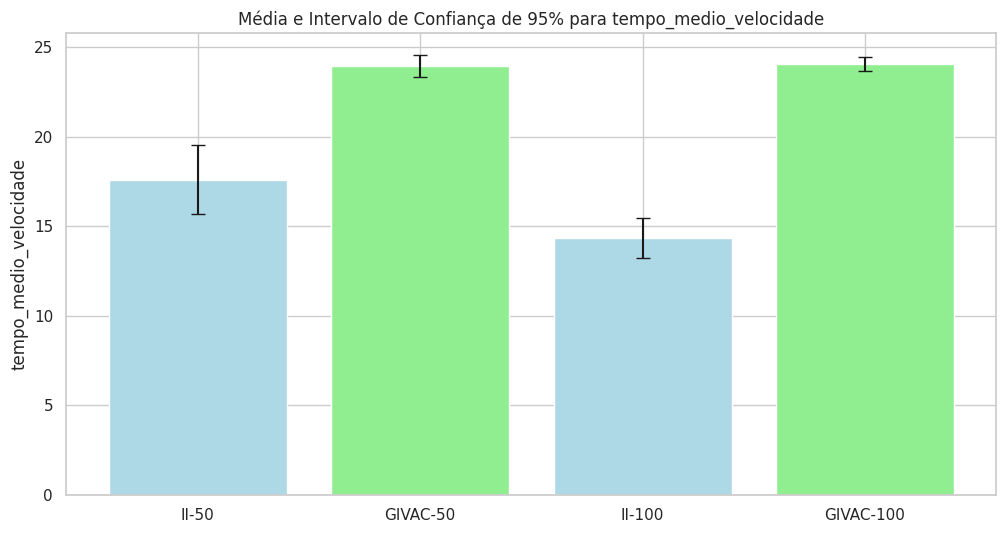

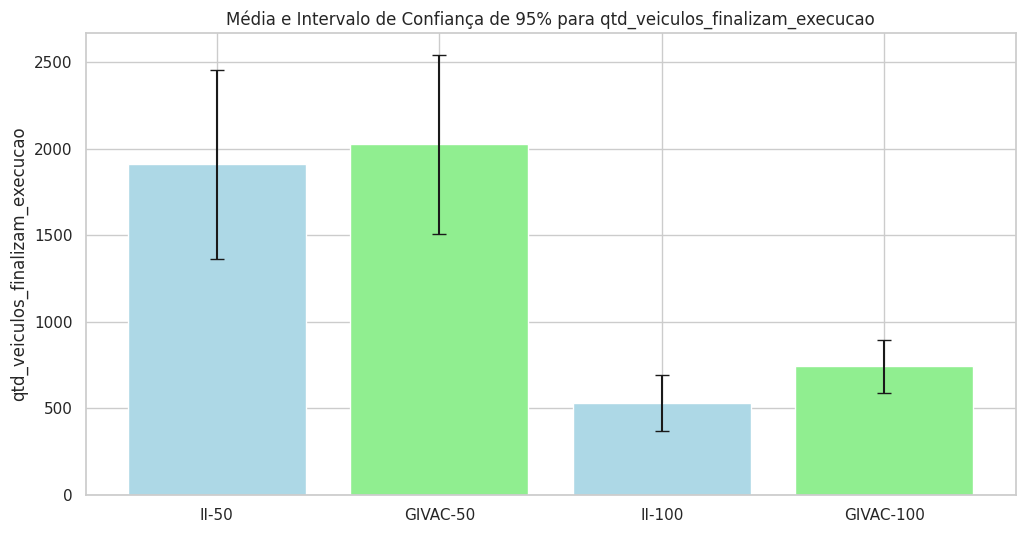

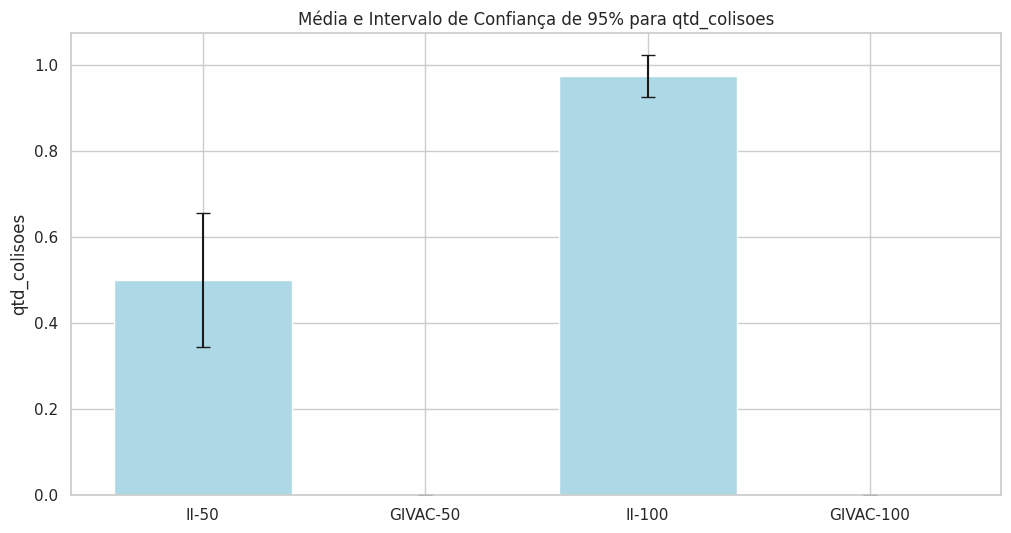

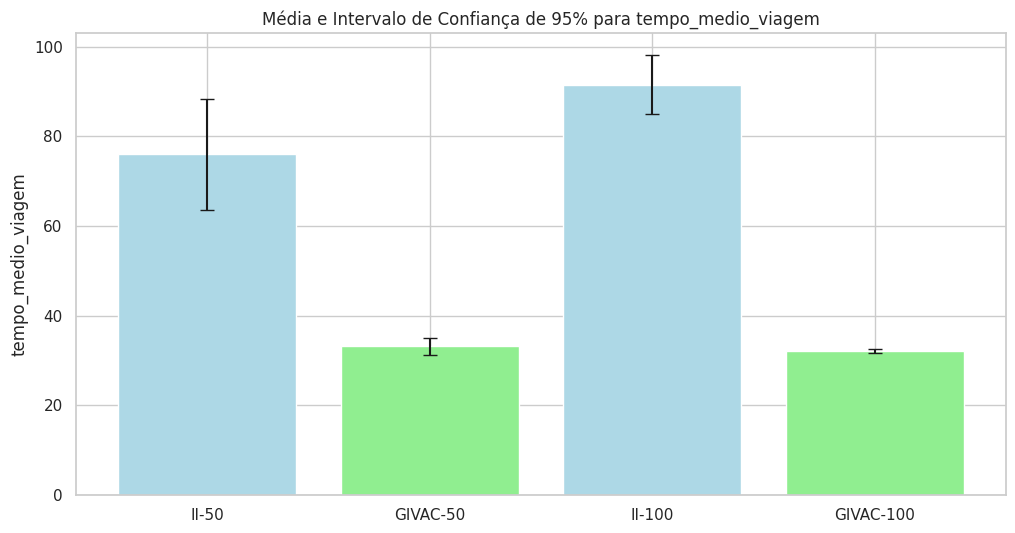

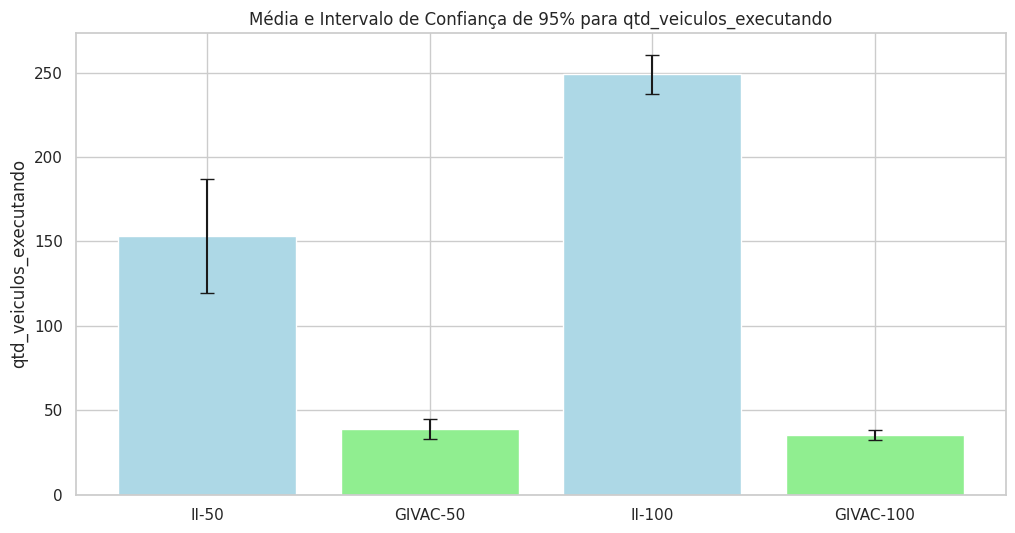

In [26]:
calc_interval(grouped,var_resposta,n=n_experiment, rotation = 0)

### Calculo em relação ao prob_add_carros

In [27]:
var = 'prob_add_carros'
n_experiment = len(df.query("algoritmo == 'GIVAC' & range_no_data == 50"))
list_grouped = ['algoritmo']+[var]
lista_index_temp = list(set(lista_index) - set([var]))
grouped = df.drop(columns=['seed','id']+lista_index_temp).groupby(list_grouped).agg(['mean','std']).reset_index()
grouped['id'] = grouped[list_grouped].apply(lambda x: '-'.join(x.astype(str)), axis=1)
grouped.sort_values(by=[var]+['algoritmo'],ascending=[True,False], inplace=True)

grouped

algoritmo prob_add_carros   stepLast                tempo_medio_viagem  \
                                  mean            std               mean   
2        II             0.4  173725.50  122463.210529          82.748133   
0     GIVAC             0.4  173725.50  122463.210529          31.899384   
3        II             0.6  119286.75  140806.631689          84.714975   
1     GIVAC             0.6  119286.75  140806.631689          33.334227   

             tempo_medio_velocidade           qtd_colisoes            \
         std                   mean       std         mean       std   
2  39.392474              17.930269  5.091747        0.725  0.452203   
0   0.861331              24.695491  0.612898        0.000  0.000000   
3  25.403678              14.025832  4.834160        0.750  0.438529   
1   6.135619              23.339661  2.041561        0.000  0.000000   

  total_veh_inseridos              qtd_veiculos_finalizam_execucao  \
                 mean          std                            mean   
2            1403.300   990.495711                        1213.350   
0            1403.300   990.495711                        1375.050   
3            1439.025  1700.475642                        1226.900   
1            1439.025  1700.475642                        1393.225   

               qtd_veiculos_executando                     id  
           std                    mean         std             
2  1085.095542                 189.950  100.419364     II-0.4  
0   989.589787                  28.250    4.074624  GIVAC-0.4  
3  1782.539945                 212.125   86.935339     II-0.6  
1  1702.284310                  45.800   16.422624  GIVAC-0.6

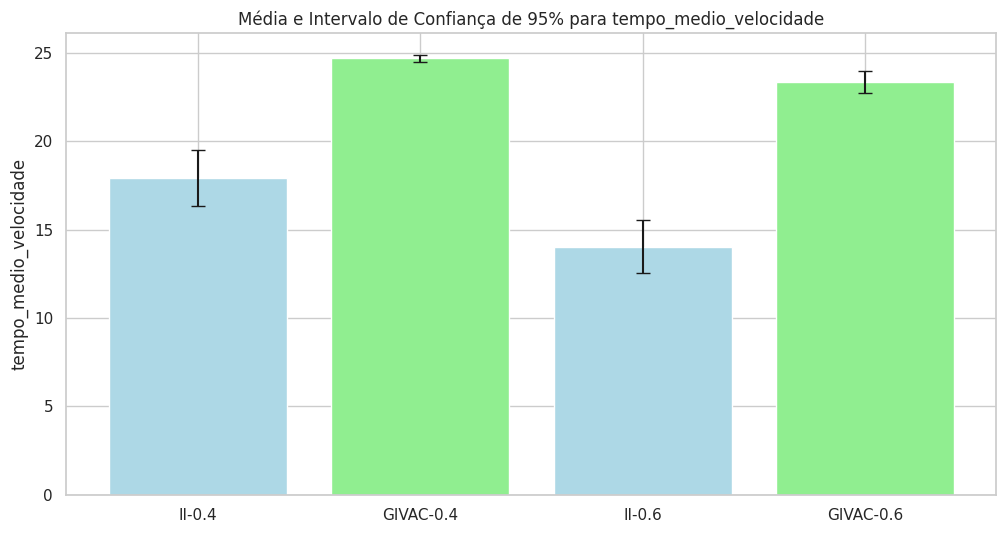

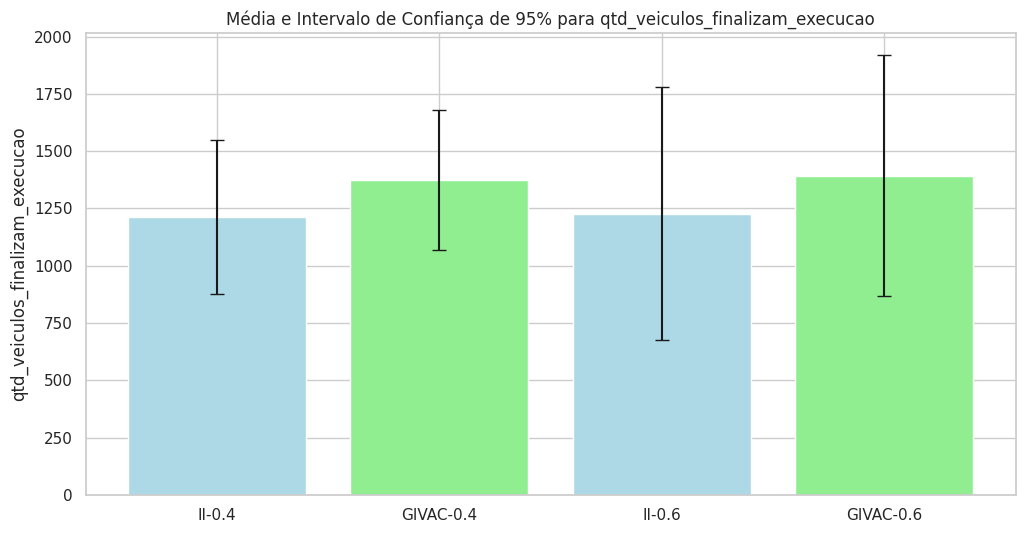

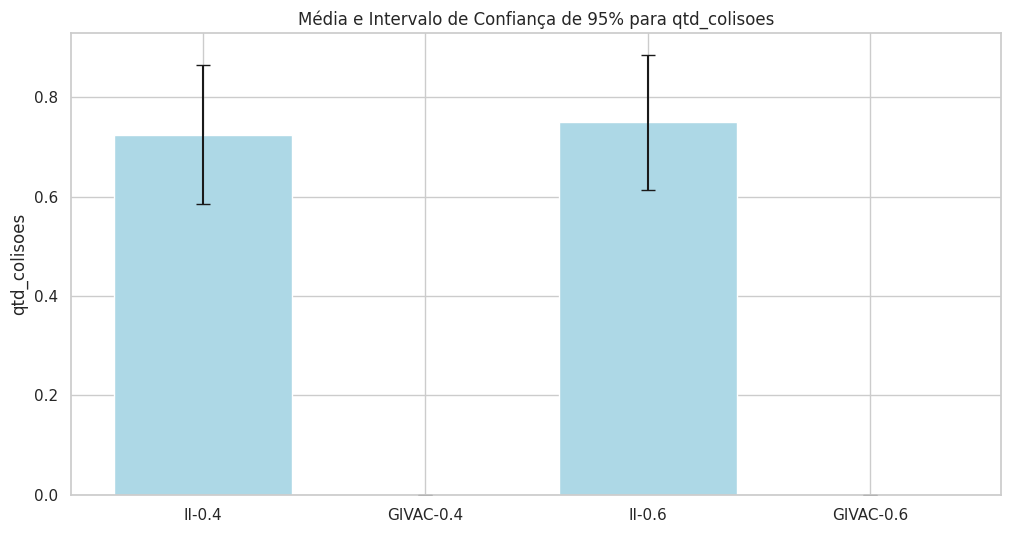

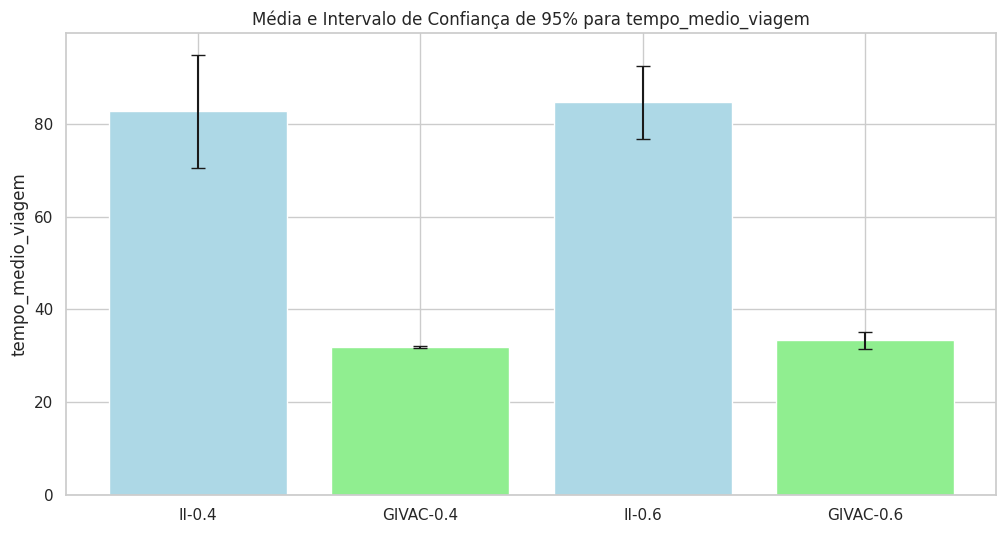

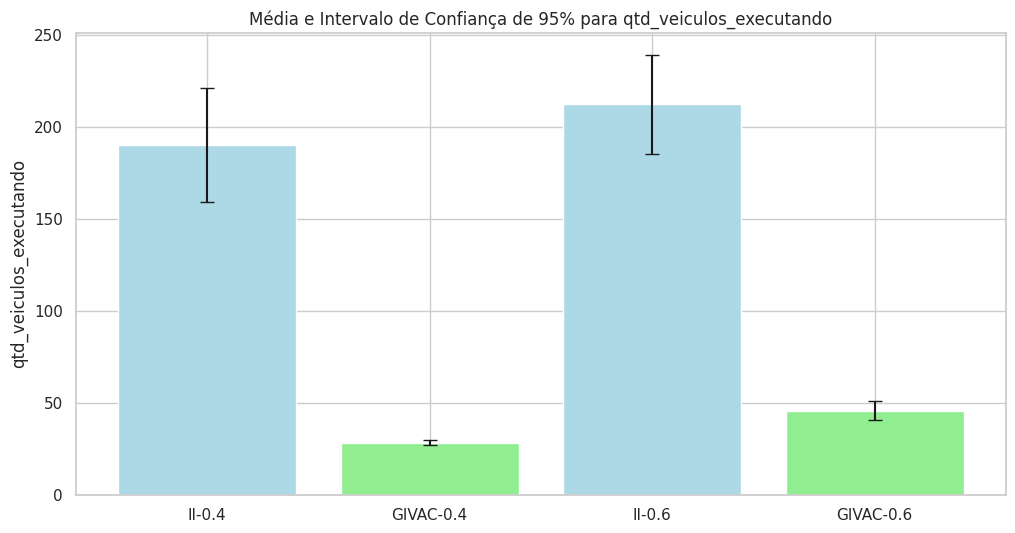

In [28]:
calc_interval(grouped,var_resposta,n=n_experiment, rotation = 0)

### Calculo em relação ao pista_problematica

In [29]:
var = 'pista_problematica'
n_experiment = len(df.query("algoritmo == 'GIVAC' & range_no_data == 50"))
list_grouped = ['algoritmo']+[var]
lista_index_temp = list(set(lista_index) - set([var]))
grouped = df.drop(columns=['seed','id']+lista_index_temp).groupby(list_grouped).agg(['mean','std']).reset_index()
grouped['id'] = grouped[list_grouped].apply(lambda x: '-'.join(x.astype(str)), axis=1)
grouped.sort_values(by=[var]+['algoritmo'],ascending=[True,False], inplace=True)

grouped

algoritmo pista_problematica   stepLast                tempo_medio_viagem  \
                                     mean            std               mean   
2        II                  7  221657.25  145804.524405          65.802096   
0     GIVAC                  7  221657.25  145804.524405          31.237787   
3        II                all   71355.00   59157.088086         101.661011   
1     GIVAC                all   71355.00   59157.088086          33.995823   

             tempo_medio_velocidade           qtd_colisoes            \
         std                   mean       std         mean       std   
2  33.478543              19.017525  5.527047        0.500  0.506370   
0   0.532533              24.866589  0.376485        0.000  0.000000   
3  20.466279              12.938576  2.759334        0.975  0.158114   
1   5.937929              23.168563  1.966206        0.000  0.000000   

  total_veh_inseridos              qtd_veiculos_finalizam_execucao  \
                 mean          std                            mean   
2            2190.975  1572.078087                        2037.675   
0            2190.975  1572.078087                        2155.525   
3             651.350   431.637879                         402.575   
1             651.350   431.637879                         612.750   

               qtd_veiculos_executando                     id  
           std                    mean         std             
2  1664.742274                 153.300  108.920390       II-7  
0  1570.244763                  35.450    8.378697    GIVAC-7  
3   461.037953                 248.775   36.820067     II-all  
1   436.999369                  38.600   19.208438  GIVAC-all

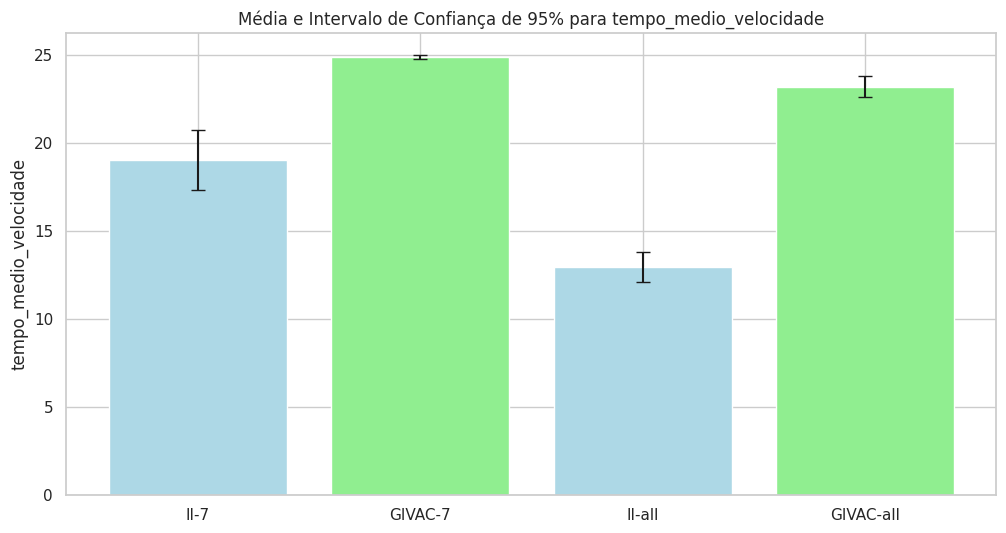

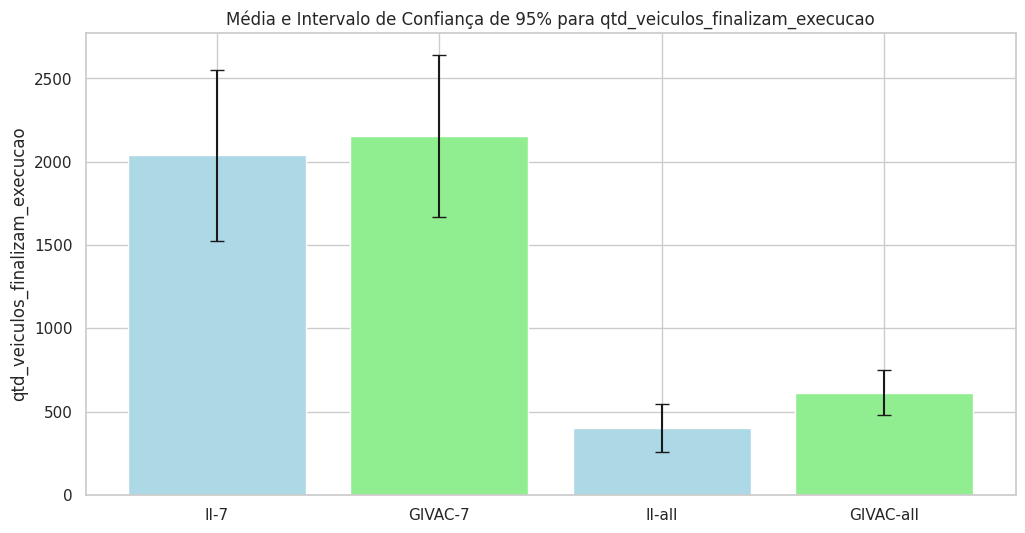

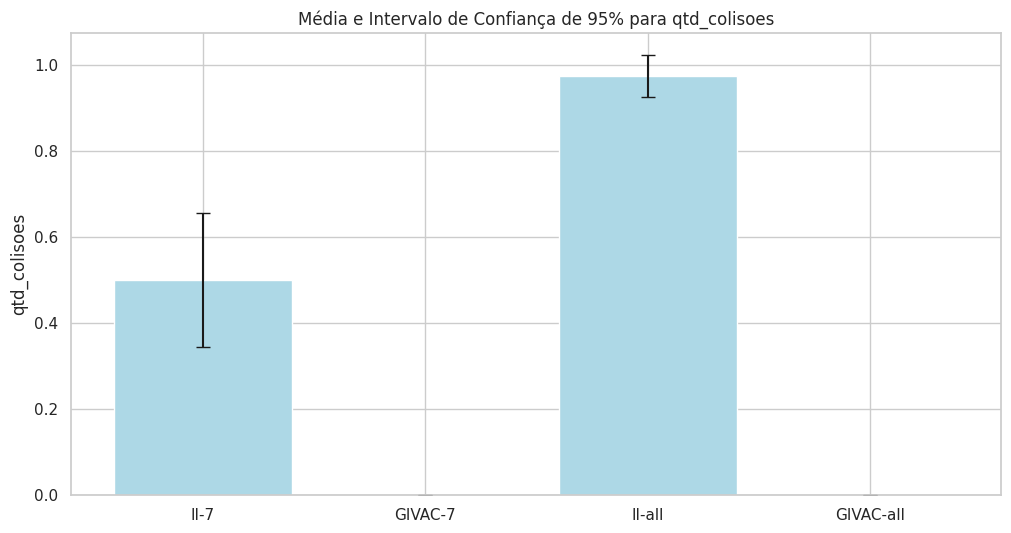

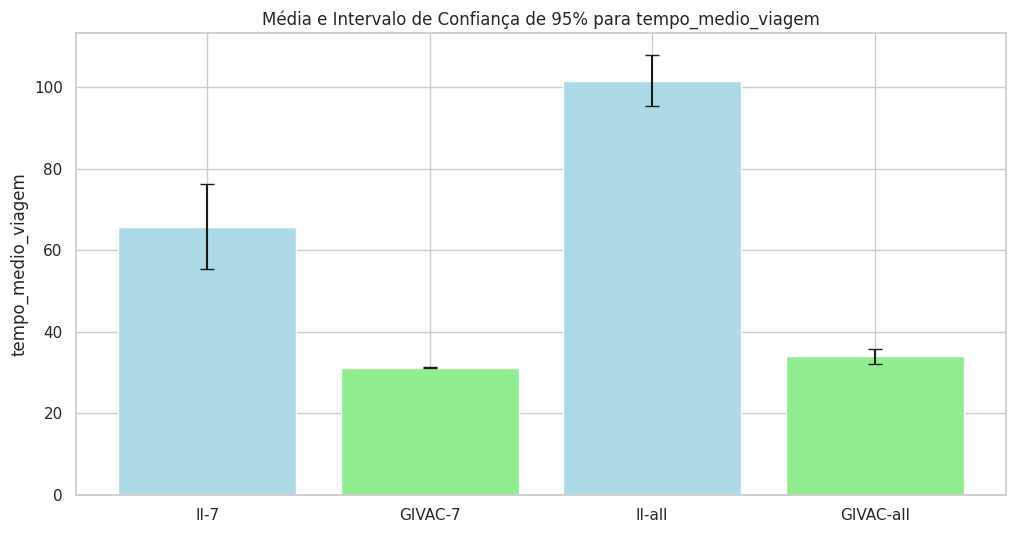

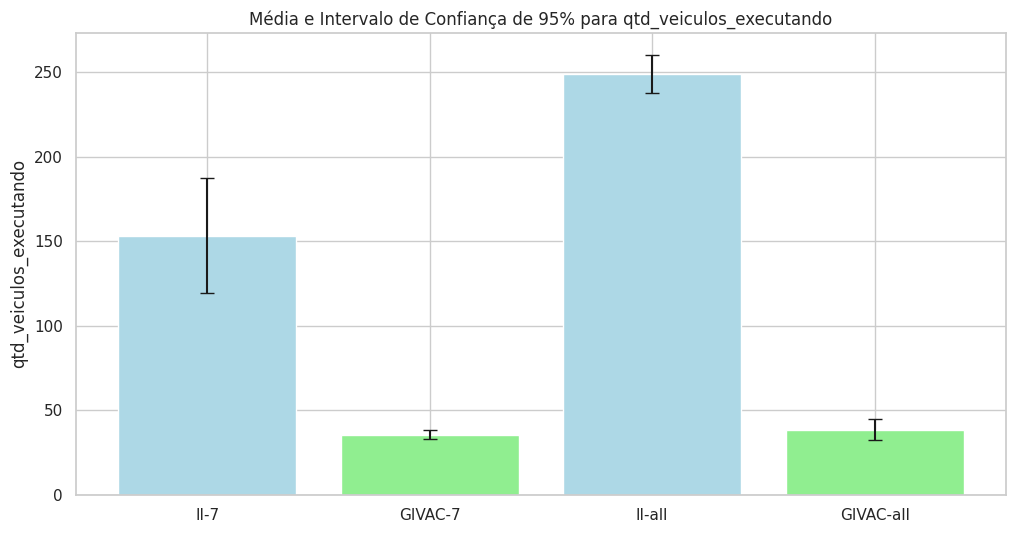

In [30]:
calc_interval(grouped,var_resposta,n=n_experiment, rotation = 0)